<a href="https://colab.research.google.com/github/chayn1v/temp_lightgbm/blob/main/lightgbm_lvl2_get_rid_of_extras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##submission_11_23_ave_salary. 
 

In [1]:
try:
  drive
  print('Drive Mounted already')
except:
  NameError
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#install gps support for LightGBM : https://www.kaggle.com/slavikonnikov/lightgbm-gpu-baseline-model-for-google-colab
 
# After running
try:
  lgb.__version__
  print('lgb imported')  
except:
  NameError
  print('installing GPS-enabled LightGBM ')
  ! git clone --recursive https://github.com/Microsoft/LightGBM
  #You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
  
  ! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu; 

installing GPS-enabled LightGBM 
fatal: destination path 'LightGBM' already exists and is not an empty directory.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.

In [3]:
import sys
import re 
import pandas as pd
import numpy as np
from itertools import product
#import pandas_profiling
import gc
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
gc.collect()

0

In [4]:
#Version check
lgb.__version__

'3.1.0.99'

In [5]:
def downcast_dtypes(df):
    ''' provided for efficiency (in class)
        Changes column types in the dataframe: 
                
                `float64` type to `float16`
                `int64`   type to `int16`
    '''
    before=df.memory_usage(index=True).sum()/1024**2
    print('original dataframe size', before,' MBs')
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    max_int_cols =   [df[c].max() for c in int_cols]  


    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    for i in range(len(int_cols)):
      if max_int_cols[i]<127:
        type_int=np.int8
      else:
        type_int=np.int16
      df[int_cols[i]]=df[int_cols[i]].astype(type_int)    

    #df[int_cols]   = df[int_cols].astype(np.int16)
    after=df.memory_usage(index=True).sum()/1024**2
    reduction=after/before
    print('downcasted  dataframe  size', after,' MBs')
    print('fraction of original memory size: ', reduction)
    return df    
  
def fix_col_names(db_cols):
  '''flattening after aggregation'''
  db_cols= [col[0] if col[-1]=='' else col[-1] for col in db_cols.values]
  
  return db_cols
  
def is_nan_check(df,cols=None):
  if cols==None:
    cols=list(df.columns.values)

  for col in cols:
     
    print(col, ' is nan count ', pd.isnull(df[col]).sum(), ' ; mean ',pd.isnull(df[col]).mean()) 


In [6]:
#adding average income in each city
city_income=pd.read_csv('drive/My Drive/Colab Notebooks/week_3/city_income.csv', encoding='utf8')
city_income=downcast_dtypes(city_income)
 

original dataframe size 0.00103759765625  MBs
downcasted  dataframe  size 0.000293731689453125  MBs
fraction of original memory size:  0.28308823529411764


In [7]:
#LOADING DATA COLUMN NAMES
path='drive/My Drive/Colab Notebooks/week_3/'
def loader_cols(file_names):
  x=[]
  for name in file_names:
    grid_cols=list(pd.read_csv(path+name+'.csv', nrows=1, encoding='utf8').columns.values)
    #Duct_tape:
    #grid_cols.remove('Unnamed: 0') 

    print(len(grid_cols),grid_cols )
    x.append((name, len(grid_cols),grid_cols ))
  return x

#SELECTING FEATURES FROM DF BY LAGS
def select_features (col_list,lags):
  selected=[]
  patt=''
  for i in lags:
    pattr='lag_%i'%i
    if patt!='':
      patt+='|'  
    patt=patt+'('+pattr +'$)'
  
  #print('patt =',patt) 
  #print('patt',patt, re.compile(patt)) 

  for col in col_list:
    if re.search('_lag',col)==None:
      #print('add', col)
      selected.append(col)
    if (re.search(patt,col)!=None):
      #print('column',col)
      #print(re.search(patt,col) )
      selected.append(col)
  return selected 


file_names=["grid1",	    
"grid_grouplist",	   
"grid_item_cat_month",    
"grid_item_city",	    
"grid_item_month",   
"grid_shop_code1_month",  
"grid_shop_month"]	


grid_columns=loader_cols(file_names) 
 




45 ['shop_id', 'item_id', 'date_block_num', 'target', 'min_price_month_lag_1', 'rev_per_item_lag_1', 'max_price_month_lag_1', 'std_price_month_lag_1', 'mean_price_month_lag_1', 'shop_rev_lag_1', 'target_lag_1', 'min_price_month_lag_2', 'rev_per_item_lag_2', 'max_price_month_lag_2', 'std_price_month_lag_2', 'mean_price_month_lag_2', 'shop_rev_lag_2', 'target_lag_2', 'min_price_month_lag_3', 'rev_per_item_lag_3', 'max_price_month_lag_3', 'std_price_month_lag_3', 'mean_price_month_lag_3', 'shop_rev_lag_3', 'target_lag_3', 'min_price_month_lag_4', 'rev_per_item_lag_4', 'max_price_month_lag_4', 'std_price_month_lag_4', 'mean_price_month_lag_4', 'shop_rev_lag_4', 'target_lag_4', 'min_price_month_lag_12', 'rev_per_item_lag_12', 'max_price_month_lag_12', 'std_price_month_lag_12', 'mean_price_month_lag_12', 'shop_rev_lag_12', 'target_lag_12', 'target_diff', 'mean_price_month_diff', 'std_price_month_diff', 'rev_per_item_diff', 'shop_rev_diff', 'shop_history']
21 ['shop_id', 'item_id', 'date_bloc

In [8]:
def delete_pattern_cols(patt,columns_list):
  l=[]
  counter=0
  for x in columns_list:
    if x.find(patt)>-1:
      #print('excluding ', x)
      counter+=1
      pass
    else:
      #print('INCLUDING ', x)
      l.append(x)
  print(counter)    
  return l      

#test
cols=['shop_id', 'item_id', 'date_block_num', 'target', 'min_price_month_lag_1', 'rev_per_item_lag_1', 'max_price_month_lag_1', 'std_price_month_lag_1', 'mean_price_month_lag_1', 'shop_rev_lag_1', 'target_lag_1', 'min_price_month_lag_2', 'rev_per_item_lag_2', 'max_price_month_lag_2', 'std_price_month_lag_2', 'mean_price_month_lag_2', 'shop_rev_lag_2', 'target_lag_2', 'min_price_month_lag_3', 'rev_per_item_lag_3', 'max_price_month_lag_3', 'std_price_month_lag_3', 'mean_price_month_lag_3', 'shop_rev_lag_3', 'target_lag_3', 'min_price_month_lag_4', 'rev_per_item_lag_4', 'max_price_month_lag_4', 'std_price_month_lag_4', 'mean_price_month_lag_4', 'shop_rev_lag_4', 'target_lag_4', 'min_price_month_lag_12', 'rev_per_item_lag_12', 'max_price_month_lag_12', 'std_price_month_lag_12', 'mean_price_month_lag_12', 'shop_rev_lag_12', 'target_lag_12', 'target_diff', 'mean_price_month_diff', 'std_price_month_diff', 'rev_per_item_diff', 'shop_rev_diff', 'shop_history']
patt='_diff'
res=delete_pattern_cols(patt,cols)
print(len(cols),len(res),res )

5
45 40 ['shop_id', 'item_id', 'date_block_num', 'target', 'min_price_month_lag_1', 'rev_per_item_lag_1', 'max_price_month_lag_1', 'std_price_month_lag_1', 'mean_price_month_lag_1', 'shop_rev_lag_1', 'target_lag_1', 'min_price_month_lag_2', 'rev_per_item_lag_2', 'max_price_month_lag_2', 'std_price_month_lag_2', 'mean_price_month_lag_2', 'shop_rev_lag_2', 'target_lag_2', 'min_price_month_lag_3', 'rev_per_item_lag_3', 'max_price_month_lag_3', 'std_price_month_lag_3', 'mean_price_month_lag_3', 'shop_rev_lag_3', 'target_lag_3', 'min_price_month_lag_4', 'rev_per_item_lag_4', 'max_price_month_lag_4', 'std_price_month_lag_4', 'mean_price_month_lag_4', 'shop_rev_lag_4', 'target_lag_4', 'min_price_month_lag_12', 'rev_per_item_lag_12', 'max_price_month_lag_12', 'std_price_month_lag_12', 'mean_price_month_lag_12', 'shop_rev_lag_12', 'target_lag_12', 'shop_history']


In [9]:

selected_fea=7*[[]]
patt="_diff"

for i in range(len(grid_columns)):
  selected_fea[i]=delete_pattern_cols(patt, grid_columns[i][2])

patt="days_"

selected_fea[6] =delete_pattern_cols(patt,selected_fea[6])

#filtering lags:
lags=[1,2,3,4]
l=[]
for lis in selected_fea:
  l.append(select_features (lis,lags))
selected_fea=l


5
3
2
3
1
0
1
5


In [10]:
selected_fea

[['shop_id',
  'item_id',
  'date_block_num',
  'target',
  'min_price_month_lag_1',
  'rev_per_item_lag_1',
  'max_price_month_lag_1',
  'std_price_month_lag_1',
  'mean_price_month_lag_1',
  'shop_rev_lag_1',
  'target_lag_1',
  'min_price_month_lag_2',
  'rev_per_item_lag_2',
  'max_price_month_lag_2',
  'std_price_month_lag_2',
  'mean_price_month_lag_2',
  'shop_rev_lag_2',
  'target_lag_2',
  'min_price_month_lag_3',
  'rev_per_item_lag_3',
  'max_price_month_lag_3',
  'std_price_month_lag_3',
  'mean_price_month_lag_3',
  'shop_rev_lag_3',
  'target_lag_3',
  'min_price_month_lag_4',
  'rev_per_item_lag_4',
  'max_price_month_lag_4',
  'std_price_month_lag_4',
  'mean_price_month_lag_4',
  'shop_rev_lag_4',
  'target_lag_4',
  'shop_history'],
 ['shop_id',
  'item_id',
  'date_block_num',
  'item_groupllist_count_lag_1',
  'item_groupllist_target_lag_1',
  'ratio_lag_1',
  'item_groupllist_count_lag_2',
  'item_groupllist_target_lag_2',
  'ratio_lag_2',
  'item_groupllist_count_

In [11]:
print(file_names)
grid1 =pd.read_csv (path+'grid1'+'.csv' ,usecols=selected_fea[0], encoding='utf8')  
#print(grid1.head())  

['grid1', 'grid_grouplist', 'grid_item_cat_month', 'grid_item_city', 'grid_item_month', 'grid_shop_code1_month', 'grid_shop_month']


In [12]:

print(grid1.head().T)
#grid1=grid1.drop(['target_diff', 'rev_per_item_diff','shop_history'   ],axis=1)

                              0       1       2       3       4
shop_id                    59.0    59.0    59.0    59.0    59.0
item_id                 22154.0  2552.0  2554.0  2555.0  2564.0
date_block_num              0.0     0.0     0.0     0.0     0.0
target                      1.0     0.0     0.0     0.0     0.0
min_price_month_lag_1       NaN     NaN     NaN     NaN     NaN
rev_per_item_lag_1          0.0     0.0     0.0     0.0     0.0
max_price_month_lag_1       NaN     NaN     NaN     NaN     NaN
std_price_month_lag_1       NaN     NaN     NaN     NaN     NaN
mean_price_month_lag_1      NaN     NaN     NaN     NaN     NaN
shop_rev_lag_1              0.0     0.0     0.0     0.0     0.0
target_lag_1                0.0     0.0     0.0     0.0     0.0
min_price_month_lag_2       NaN     NaN     NaN     NaN     NaN
rev_per_item_lag_2          0.0     0.0     0.0     0.0     0.0
max_price_month_lag_2       NaN     NaN     NaN     NaN     NaN
std_price_month_lag_2       NaN     NaN 

In [13]:
print(grid1.head().T)

grid1=pd.merge(grid1,city_income,how='left', on='shop_id')
print(grid1.head().T)



                              0       1       2       3       4
shop_id                    59.0    59.0    59.0    59.0    59.0
item_id                 22154.0  2552.0  2554.0  2555.0  2564.0
date_block_num              0.0     0.0     0.0     0.0     0.0
target                      1.0     0.0     0.0     0.0     0.0
min_price_month_lag_1       NaN     NaN     NaN     NaN     NaN
rev_per_item_lag_1          0.0     0.0     0.0     0.0     0.0
max_price_month_lag_1       NaN     NaN     NaN     NaN     NaN
std_price_month_lag_1       NaN     NaN     NaN     NaN     NaN
mean_price_month_lag_1      NaN     NaN     NaN     NaN     NaN
shop_rev_lag_1              0.0     0.0     0.0     0.0     0.0
target_lag_1                0.0     0.0     0.0     0.0     0.0
min_price_month_lag_2       NaN     NaN     NaN     NaN     NaN
rev_per_item_lag_2          0.0     0.0     0.0     0.0     0.0
max_price_month_lag_2       NaN     NaN     NaN     NaN     NaN
std_price_month_lag_2       NaN     NaN 

In [14]:
print(selected_fea[1])
grid_grouplist=pd.read_csv (path+'grid_grouplist'+'.csv' ,usecols=selected_fea[1], encoding='utf8')  

 
grid1=pd.merge(grid1,grid_grouplist,on=['shop_id' ,'item_id' ,'date_block_num'], how='left')

is_nan_check(grid1)     

['shop_id', 'item_id', 'date_block_num', 'item_groupllist_count_lag_1', 'item_groupllist_target_lag_1', 'ratio_lag_1', 'item_groupllist_count_lag_2', 'item_groupllist_target_lag_2', 'ratio_lag_2', 'item_groupllist_count_lag_3', 'item_groupllist_target_lag_3', 'ratio_lag_3', 'item_groupllist_count_lag_4', 'item_groupllist_target_lag_4', 'ratio_lag_4']
shop_id  is nan count  0  ; mean  0.0
item_id  is nan count  0  ; mean  0.0
date_block_num  is nan count  0  ; mean  0.0
target  is nan count  0  ; mean  0.0
min_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
rev_per_item_lag_1  is nan count  0  ; mean  0.0
max_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
std_price_month_lag_1  is nan count  10573700  ; mean  0.9528249077335821
mean_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
shop_rev_lag_1  is nan count  0  ; mean  0.0
target_lag_1  is nan count  0  ; mean  0.0
min_price_month_lag_2  is nan count  9640503  ; mean  0.86

In [15]:
del grid_grouplist
gc.collect()

0

In [16]:
grid1=downcast_dtypes(grid1)

original dataframe size 3915.7566452026367  MBs
downcasted  dataframe  size 1037.146354675293  MBs
fraction of original memory size:  0.2648648648648649


In [17]:
items = pd.read_csv(path+'items.csv', encoding='utf8') 
grid1=pd.merge(grid1, items[['item_id','item_category_id']] ,on='item_id', how='left')
del items

In [18]:
grid_item_cat_month=pd.read_csv (path+'grid_item_cat_month' +'.csv' ,usecols=selected_fea[2], encoding='utf8') 
print(selected_fea[2])
grid1=pd.merge(grid1,grid_item_cat_month,on=['shop_id' ,'item_category_id','date_block_num'], how='left')

is_nan_check(grid1)   
del grid_item_cat_month
gc.collect()  

['shop_id', 'item_category_id', 'date_block_num', 'shop_item_cat_target_per_day_lag_1', 'shop_item_cat_mean_price_lag_1', 'shop_item_cat_target_lag_1', 'shop_item_cat_target_per_day_lag_2', 'shop_item_cat_mean_price_lag_2', 'shop_item_cat_target_lag_2', 'shop_item_cat_target_per_day_lag_3', 'shop_item_cat_mean_price_lag_3', 'shop_item_cat_target_lag_3', 'shop_item_cat_target_per_day_lag_4', 'shop_item_cat_mean_price_lag_4', 'shop_item_cat_target_lag_4']
shop_id  is nan count  0  ; mean  0.0
item_id  is nan count  0  ; mean  0.0
date_block_num  is nan count  0  ; mean  0.0
target  is nan count  0  ; mean  0.0
min_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
rev_per_item_lag_1  is nan count  0  ; mean  0.0
max_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
std_price_month_lag_1  is nan count  10573700  ; mean  0.9528249077335821
mean_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
shop_rev_lag_1  is nan count  0  ; mean  

0

In [19]:
path1='drive/My Drive/'
shops2=pd.read_csv(path1+'shops2.csv', encoding='utf8')
shops2=shops2.drop('shop_name',axis=1)
grid1=pd.merge(grid1, shops2[['shop_id','city_code']] ,on='shop_id', how='left')

grid_item_city=pd.read_csv (path+'grid_item_city' +'.csv' ,usecols=selected_fea[3], encoding='utf8')  
print(selected_fea[3])
grid1=pd.merge(grid1,grid_item_city,on=['city_code' ,'item_id','date_block_num'], how='left')

is_nan_check(grid1)   
del grid_item_city 
gc.collect()

['item_id', 'city_code', 'date_block_num', 'mean_item_per_active_city_code_lag_1', 'item_active_city_code_count_lag_1', 'target_item_city_code_lag_1', 'mean_item_per_active_city_code_lag_2', 'item_active_city_code_count_lag_2', 'target_item_city_code_lag_2', 'mean_item_per_active_city_code_lag_3', 'item_active_city_code_count_lag_3', 'target_item_city_code_lag_3', 'mean_item_per_active_city_code_lag_4', 'item_active_city_code_count_lag_4', 'target_item_city_code_lag_4']
shop_id  is nan count  0  ; mean  0.0
item_id  is nan count  0  ; mean  0.0
date_block_num  is nan count  0  ; mean  0.0
target  is nan count  0  ; mean  0.0
min_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
rev_per_item_lag_1  is nan count  0  ; mean  0.0
max_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
std_price_month_lag_1  is nan count  10573700  ; mean  0.9528249077335821
mean_price_month_lag_1  is nan count  9570563  ; mean  0.8624295003105285
shop_rev_lag_1  is nan c

0

In [20]:
downcast_dtypes(grid1)
gc.collect()

original dataframe size 3238.4365768432617  MBs
downcasted  dataframe  size 1566.3026580810547  MBs
fraction of original memory size:  0.48366013071895425


0

In [21]:
grid1.dtypes

shop_id                                    int8
item_id                                   int16
date_block_num                             int8
target                                  float16
min_price_month_lag_1                   float16
                                         ...   
item_active_city_code_count_lag_3       float16
target_item_city_code_lag_3             float16
mean_item_per_active_city_code_lag_4    float16
item_active_city_code_count_lag_4       float16
target_item_city_code_lag_4             float16
Length: 72, dtype: object

In [22]:
selected_fea[4]=selected_fea[4]+['target_item_lag_12']

In [23]:
print(selected_fea[4])
grid_item_month=pd.read_csv (path+'grid_item_month' +'.csv' ,usecols=selected_fea[4], encoding='utf8')
 
  
 
grid1=pd.merge(grid1,grid_item_month,on=['item_id','date_block_num'], how='left')

is_nan_check(grid1[grid_item_month.columns])   
del grid_item_month
gc.collect()

['item_id', 'date_block_num', 'item_active_shop_count_lag_1', 'mean_item_per_active_shop_lag_1', 'target_item_lag_1', 'item_active_shop_count_lag_2', 'mean_item_per_active_shop_lag_2', 'target_item_lag_2', 'item_active_shop_count_lag_3', 'mean_item_per_active_shop_lag_3', 'target_item_lag_3', 'item_active_shop_count_lag_4', 'mean_item_per_active_shop_lag_4', 'target_item_lag_4', 'history', 'target_item_lag_12']
item_id  is nan count  0  ; mean  0.0
date_block_num  is nan count  0  ; mean  0.0
item_active_shop_count_lag_1  is nan count  0  ; mean  0.0
mean_item_per_active_shop_lag_1  is nan count  0  ; mean  0.0
target_item_lag_1  is nan count  0  ; mean  0.0
item_active_shop_count_lag_2  is nan count  0  ; mean  0.0
mean_item_per_active_shop_lag_2  is nan count  0  ; mean  0.0
target_item_lag_2  is nan count  0  ; mean  0.0
item_active_shop_count_lag_3  is nan count  0  ; mean  0.0
mean_item_per_active_shop_lag_3  is nan count  0  ; mean  0.0
target_item_lag_3  is nan count  0  ; mean 

0

In [24]:
print(selected_fea[5])
s_items1=pd.read_csv(path1+'s_items1.csv', encoding='utf8') 
grid1=pd.merge(grid1,s_items1[['item_id','code_item_id1']],on='item_id', how='left')
grid_shop_code1_month=pd.read_csv (path+'grid_shop_code1_month' +'.csv' ,usecols=selected_fea[5], encoding='utf8') 
grid1=pd.merge(grid1,grid_shop_code1_month ,on=['shop_id', 'code_item_id1', 'date_block_num',], how='left')

is_nan_check(grid1[grid_shop_code1_month.columns]) 

grid1=downcast_dtypes(grid1)
del grid_shop_code1_month
gc.collect()

['shop_id', 'code_item_id1', 'date_block_num', 'mean_target_shop_code1_lag_1', 'shop_code1_count_lag_1', 'target_shop_code1_lag_1', 'mean_target_shop_code1_lag_2', 'shop_code1_count_lag_2', 'target_shop_code1_lag_2', 'mean_target_shop_code1_lag_3', 'shop_code1_count_lag_3', 'target_shop_code1_lag_3', 'mean_target_shop_code1_lag_4', 'shop_code1_count_lag_4', 'target_shop_code1_lag_4']
shop_id  is nan count  0  ; mean  0.0
code_item_id1  is nan count  0  ; mean  0.0
date_block_num  is nan count  0  ; mean  0.0
mean_target_shop_code1_lag_1  is nan count  0  ; mean  0.0
shop_code1_count_lag_1  is nan count  0  ; mean  0.0
target_shop_code1_lag_1  is nan count  0  ; mean  0.0
mean_target_shop_code1_lag_2  is nan count  0  ; mean  0.0
shop_code1_count_lag_2  is nan count  0  ; mean  0.0
target_shop_code1_lag_2  is nan count  0  ; mean  0.0
mean_target_shop_code1_lag_3  is nan count  0  ; mean  0.0
shop_code1_count_lag_3  is nan count  0  ; mean  0.0
target_shop_code1_lag_3  is nan count  0  

0

In [25]:
 selected_fea[6]= selected_fea[6]+['target_shop_lag_12']

In [26]:
grid_shop_month=pd.read_csv (path+'grid_shop_month' +'.csv' ,usecols=selected_fea[6], encoding='utf8') 
grid1=pd.merge(grid1,grid_shop_month ,on=['shop_id',   'date_block_num'], how='left')
is_nan_check(grid1[grid_shop_month.columns]) 
grid1=downcast_dtypes(grid1)
del grid_shop_month
gc.collect()







shop_id  is nan count  0  ; mean  0.0
date_block_num  is nan count  0  ; mean  0.0
days  is nan count  0  ; mean  0.0
target_shop_lag_1  is nan count  0  ; mean  0.0
target_shop_lag_2  is nan count  0  ; mean  0.0
target_shop_lag_3  is nan count  0  ; mean  0.0
target_shop_lag_4  is nan count  0  ; mean  0.0
target_shop_lag_12  is nan count  0  ; mean  0.0
month  is nan count  0  ; mean  0.0
year  is nan count  0  ; mean  0.0
original dataframe size 2815.1115341186523  MBs
downcasted  dataframe  size 2275.3721046447754  MBs
fraction of original memory size:  0.8082706766917294


0

In [27]:
#grid_item_cat_month=pd.read_csv (path+'grid_item_cat_month' +'.csv' ,usecols=selected_fea[2], encoding='utf8') 
#grid_item_city=pd.read_csv (path+'grid_item_city' +'.csv' ,usecols=selected_fea[3], encoding='utf8') 
#grid_item_month=pd.read_csv (path+'grid_item_month' +'.csv' ,usecols=selected_fea[4], encoding='utf8') 
#grid_shop_code1_month=pd.read_csv (path+'grid_shop_code1_month' +'.csv' ,usecols=selected_fea[5], encoding='utf8') 
#grid_shop_month=pd.read_csv (path+'grid_shop_month' +'.csv' ,usecols=selected_fea[6], encoding='utf8') 

In [28]:
#custom_drop=['target_lag_2', 'mean_price_month_lag_2', 'std_price_month_lag_2', 'target_shop_lag_2', 'days_lag_2', 'target_item_lag_2', 'shop_item_cat_target_lag_2', 'shop_item_cat_target_per_day_lag_2']
#grid1=grid1.drop(custom_drop, axis=1)
#print(pd.read_csv(path+'grid1'+'.csv', nrows=1, encoding='utf8'))
 

In [29]:
print(grid1.shape)
print(grid1.head().T)

(11097212, 107)
                             0       1       2       3       4
shop_id                   59.0    59.0    59.0    59.0    59.0
item_id                22154.0  2552.0  2554.0  2555.0  2564.0
date_block_num             0.0     0.0     0.0     0.0     0.0
target                     1.0     0.0     0.0     0.0     0.0
min_price_month_lag_1      NaN     NaN     NaN     NaN     NaN
...                        ...     ...     ...     ...     ...
target_shop_lag_3          0.0     0.0     0.0     0.0     0.0
target_shop_lag_4          0.0     0.0     0.0     0.0     0.0
target_shop_lag_12         0.0     0.0     0.0     0.0     0.0
month                      0.0     0.0     0.0     0.0     0.0
year                       0.0     0.0     0.0     0.0     0.0

[107 rows x 5 columns]


In [30]:
 list(zip(grid1.columns,grid1.dtypes))

[('shop_id', dtype('int8')),
 ('item_id', dtype('int16')),
 ('date_block_num', dtype('int8')),
 ('target', dtype('float16')),
 ('min_price_month_lag_1', dtype('float16')),
 ('rev_per_item_lag_1', dtype('float16')),
 ('max_price_month_lag_1', dtype('float16')),
 ('std_price_month_lag_1', dtype('float16')),
 ('mean_price_month_lag_1', dtype('float16')),
 ('shop_rev_lag_1', dtype('float16')),
 ('target_lag_1', dtype('float16')),
 ('min_price_month_lag_2', dtype('float16')),
 ('rev_per_item_lag_2', dtype('float16')),
 ('max_price_month_lag_2', dtype('float16')),
 ('std_price_month_lag_2', dtype('float16')),
 ('mean_price_month_lag_2', dtype('float16')),
 ('shop_rev_lag_2', dtype('float16')),
 ('target_lag_2', dtype('float16')),
 ('min_price_month_lag_3', dtype('float16')),
 ('rev_per_item_lag_3', dtype('float16')),
 ('max_price_month_lag_3', dtype('float16')),
 ('std_price_month_lag_3', dtype('float16')),
 ('mean_price_month_lag_3', dtype('float16')),
 ('shop_rev_lag_3', dtype('float16')),

In [31]:
#custom processed:
path1='drive/My Drive/'
item_categ_p=pd.read_csv(path1+'item_categ_p.csv', encoding='utf8')
item_categ_p=item_categ_p.rename(columns={"игр_all": "games_all"})
shops2=pd.read_csv(path1+'shops2.csv', encoding='utf8')
shops2=shops2.drop('shop_name',axis=1)
 




In [32]:
print(s_items1)
text_features=[x for x in s_items1.columns.values if 'text' in x]+['item_id']
print (text_features)
#precelected text features:
#text_features_select=['text_feature_0', 'text_feature_1', 'text_feature_2', 'text_feature_3', 'text_feature_4', 'text_feature_5', 'text_feature_7', 'text_feature_8', 'text_feature_9', 'text_feature_10', 'text_feature_11', 'text_feature_13', 'text_feature_14', 'text_feature_15', 'text_feature_20']
#text_features_select=text_features_select+['item_id']

       item_id  cd_count  ...  text_feature_19  text_feature_20
0        11364         0  ...                0                0
1        14906         0  ...                0                0
2         5614         0  ...                0                0
3        11370         0  ...                0                0
4        11369         0  ...                0                0
...        ...       ...  ...              ...              ...
22165    22160         0  ...                0                0
22166    22161         0  ...              119                0
22167    22162         0  ...                0                0
22168    22163         0  ...                0                0
22169    22164         0  ...                0                0

[22170 rows x 28 columns]
['text_feature_0', 'text_feature_1', 'text_feature_2', 'text_feature_3', 'text_feature_4', 'text_feature_5', 'text_feature_6', 'text_feature_7', 'text_feature_8', 'text_feature_9', 'text_feature_10', 'text

In [33]:
item_categ_p.columns
grid1=pd.merge(grid1, item_categ_p, how='left', on='item_category_id')
grid1=pd.merge(grid1, s_items1[ text_features ], how='left', on='item_id')
 
grid1=downcast_dtypes(grid1)
#grid1=grid1.drop('item_category_id', axis=1)
grid1=grid1.drop('code_item_id1', axis=1)
#grid1=grid1.drop('item_id',axis=1) 
grid1=downcast_dtypes(grid1)

original dataframe size 4391.997318267822  MBs
downcasted  dataframe  size 2762.195903778076  MBs
fraction of original memory size:  0.6289156626506024
original dataframe size 2741.0296516418457  MBs
downcasted  dataframe  size 2741.0296516418457  MBs
fraction of original memory size:  1.0


In [34]:
grid1.columns.values
 
 


array(['shop_id', 'item_id', 'date_block_num', 'target',
       'min_price_month_lag_1', 'rev_per_item_lag_1',
       'max_price_month_lag_1', 'std_price_month_lag_1',
       'mean_price_month_lag_1', 'shop_rev_lag_1', 'target_lag_1',
       'min_price_month_lag_2', 'rev_per_item_lag_2',
       'max_price_month_lag_2', 'std_price_month_lag_2',
       'mean_price_month_lag_2', 'shop_rev_lag_2', 'target_lag_2',
       'min_price_month_lag_3', 'rev_per_item_lag_3',
       'max_price_month_lag_3', 'std_price_month_lag_3',
       'mean_price_month_lag_3', 'shop_rev_lag_3', 'target_lag_3',
       'min_price_month_lag_4', 'rev_per_item_lag_4',
       'max_price_month_lag_4', 'std_price_month_lag_4',
       'mean_price_month_lag_4', 'shop_rev_lag_4', 'target_lag_4',
       'shop_history', 'ave_salary', 'item_groupllist_count_lag_1',
       'item_groupllist_target_lag_1', 'ratio_lag_1',
       'item_groupllist_count_lag_2', 'item_groupllist_target_lag_2',
       'ratio_lag_2', 'item_groupllist_

In [35]:
cols=[]
for x in grid1.columns.values:
  if not ('lag' in x):
    cols.append(x)

print( cols)

#figuring which columns should not be in X_train/X_val/X_test
to_drop_cols =['target']#, 'mean_price_month', 'min_price_month', 'max_price_month', 'std_price_month', 'rev_per_item', 'shop_rev', 'target_diff', 'mean_price_month_diff', 'std_price_month_diff', 'rev_per_item_diff', 'shop_rev_diff',
#'target_item_city_code', 'item_active_city_code_count', 'mean_item_per_active_city_code', 'target_item_city_code_diff', 'item_active_city_code_count_diff', 'mean_item_per_active_city_code_diff', 'target_item', 'item_active_shop_count', 'mean_item_per_active_shop',
#'target_item_diff', #'code_item_id1', 
#'target_shop_code1', 'shop_code1_count', 'mean_target_shop_code1', 'target_shop','target_shop_diff']

#CHECK:

check=set(grid1.columns.values)-set(to_drop_cols) 
print('columns to stay:', check)

print('columns to stay which have no lags ', check-set([x for x in list(check) if "lag" in x]))

len(to_drop_cols )

['shop_id', 'item_id', 'date_block_num', 'target', 'shop_history', 'ave_salary', 'item_category_id', 'city_code', 'history', 'days', 'month', 'year', 'games_all', 'class1', 'class2', 'class4', 'text_feature_0', 'text_feature_1', 'text_feature_2', 'text_feature_3', 'text_feature_4', 'text_feature_5', 'text_feature_6', 'text_feature_7', 'text_feature_8', 'text_feature_9', 'text_feature_10', 'text_feature_11', 'text_feature_12', 'text_feature_13', 'text_feature_14', 'text_feature_15', 'text_feature_16', 'text_feature_17', 'text_feature_18', 'text_feature_19', 'text_feature_20']
columns to stay: {'mean_target_shop_code1_lag_3', 'target_shop_code1_lag_4', 'shop_rev_lag_2', 'target_lag_2', 'max_price_month_lag_4', 'shop_item_cat_mean_price_lag_4', 'mean_price_month_lag_4', 'shop_rev_lag_1', 'target_shop_code1_lag_3', 'shop_rev_lag_3', 'text_feature_11', 'text_feature_1', 'shop_item_cat_mean_price_lag_2', 'year', 'mean_target_shop_code1_lag_4', 'mean_price_month_lag_2', 'ratio_lag_4', 'target

1

In [36]:
#Dropping columns  
print(to_drop_cols)
#to_drop_cols.remove('date_block_num')
#to_drop_cols=to_drop_cols+['date_block_num','item_category_id' ,'city_code']
to_drop_cols=to_drop_cols+['date_block_num' ,'city_code']
#to_drop_cols.remove('item_id')
print(to_drop_cols) 


['target']
['target', 'date_block_num', 'city_code']


In [37]:
# duct tape 
#print(text_features) 
#print(grid1.columns.values )
#grid1=grid1.drop(['games_all_x',  'class1_x', 'class2_x', 'class4_x', 'games_all_y', 'class1_y', 'class2_y', 'class4_y'], axis=1 )

In [38]:
item_categ_p.columns

Index(['item_category_id', 'games_all', 'class1', 'class2', 'class4'], dtype='object')

In [39]:
# 
#grid1=pd.merge(grid1, item_categ_p, how='left', on='item_category_id')

#grid1=downcast_dtypes(grid1)


In [40]:
extra_aggregates= True
tf=True
if (extra_aggregates==True) &(tf==False) :
  for col in [ 'shop_id',  'games_all', 'class1', 'class2', 'class4', 'city_code']:
  #[ 'shop_id',   'item_category_id','games_all', 'class1', 'class2', 'class4','shop_type', 'city_code']:
  
    grid1[col] = grid1[col].astype('category')
    print(col, grid1[col].dtype)
elif (extra_aggregates==True) &(tf==True):
   #s_items1_cats=[x for x in list(s_items1.columns.values)  if (re.search('text',x)!=None)]
   text_features.remove('item_id') 
   all_cat_fea=[ 'shop_id' ,'games_all', 'class1', 'class2', 'class4', 'city_code'] +text_features #[ 'shop_id',   'item_category_id','games_all', 'class1', 'class2', 'class4','shop_type', 'city_code'] +s_items1_cats
   for col in all_cat_fea:
     
     grid1[col] = grid1[col].astype('category')
     print(col, grid1[col].dtype)

elif (extra_aggregates==False) &(tf==False) :
  for col in [ 'shop_id',   'item_category_id','city_code' ]:
    grid1[col] = grid1[col].astype('category')
    print(col, grid1[col].dtype)

else: print('Error')
 


shop_id category
games_all category
class1 category
class2 category
class4 category
city_code category
text_feature_0 category
text_feature_1 category
text_feature_2 category
text_feature_3 category
text_feature_4 category
text_feature_5 category
text_feature_6 category
text_feature_7 category
text_feature_8 category
text_feature_9 category
text_feature_10 category
text_feature_11 category
text_feature_12 category
text_feature_13 category
text_feature_14 category
text_feature_15 category
text_feature_16 category
text_feature_17 category
text_feature_18 category
text_feature_19 category
text_feature_20 category


In [41]:
last_block = grid1['date_block_num'].max()
dates = (grid1['date_block_num']<last_block-1) 
#print(dates.head())
print('Test `date_block_num` is %d' % last_block)
dates_train = (grid1['date_block_num'] <  last_block-1)
#print(dates_train.head())

Test `date_block_num` is 34


In [42]:
#We don't want to validate on shop 36: it is opened in the validation month hence no training for it happened

shop, month=36, last_block-1 
shop_36_index=((grid1 ['shop_id']==shop) & (grid1 ['date_block_num']==month))


print('last_block',last_block)
print('shop_36_index values counts',shop_36_index.value_counts())
X_shop_36=grid1[shop_36_index]
y_shop_36=grid1[shop_36_index].target.values
#Prep test
X_test = grid1.loc[grid1 ['date_block_num']==last_block].drop(to_drop_cols, axis=1)

last_block 34
shop_36_index values counts False    11091799
True         5413
dtype: int64


In [43]:
print(X_test.columns.values)
print(X_test[1000:1002].T)

['shop_id' 'item_id' 'min_price_month_lag_1' 'rev_per_item_lag_1'
 'max_price_month_lag_1' 'std_price_month_lag_1' 'mean_price_month_lag_1'
 'shop_rev_lag_1' 'target_lag_1' 'min_price_month_lag_2'
 'rev_per_item_lag_2' 'max_price_month_lag_2' 'std_price_month_lag_2'
 'mean_price_month_lag_2' 'shop_rev_lag_2' 'target_lag_2'
 'min_price_month_lag_3' 'rev_per_item_lag_3' 'max_price_month_lag_3'
 'std_price_month_lag_3' 'mean_price_month_lag_3' 'shop_rev_lag_3'
 'target_lag_3' 'min_price_month_lag_4' 'rev_per_item_lag_4'
 'max_price_month_lag_4' 'std_price_month_lag_4' 'mean_price_month_lag_4'
 'shop_rev_lag_4' 'target_lag_4' 'shop_history' 'ave_salary'
 'item_groupllist_count_lag_1' 'item_groupllist_target_lag_1'
 'ratio_lag_1' 'item_groupllist_count_lag_2'
 'item_groupllist_target_lag_2' 'ratio_lag_2'
 'item_groupllist_count_lag_3' 'item_groupllist_target_lag_3'
 'ratio_lag_3' 'item_groupllist_count_lag_4'
 'item_groupllist_target_lag_4' 'ratio_lag_4' 'item_category_id'
 'shop_item_cat_t

In [44]:
val_mask=(grid1.date_block_num == last_block-1)&(~(shop_36_index))
print('val_mask values counts',val_mask.value_counts())


val_mask values counts False    10864453
True       232759
dtype: int64


In [45]:
gc.collect()


12

In [46]:
grid1.dtypes.values 

array([CategoricalDtype(categories=[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
                  18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
                  33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
                  48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
                 ordered=False),
       dtype('int16'), dtype('int8'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), dtype('float16'), dtype('float16'),
       dtype('float16'), 

In [47]:
def lgm_from_month_M_sets(grid1,M,to_drop_cols,remove_shop_36_in_validation=True):
  ''' Training start training from month M 
      TO SAVE MEMORY M HAS TO BE INCREASING: SUBSETTING grid1, deleting months!'''
  print('current M = ',M)
  #grid1=grid1.loc[grid1['date_block_num']>=M]
  if remove_shop_36_in_validation:
       
    #All validation except shop 36
    val_mask=(grid1.date_block_num == last_block-1)&(~(shop_36_index))
    print('val_mask values counts',val_mask.value_counts())

    #Prep  train 
    dates_train = (grid1['date_block_num'] <  last_block-1)&(M<=grid1['date_block_num'])

    print('grid1.shape',grid1.shape) 
    X_train = grid1[dates_train].drop(to_drop_cols, axis=1)
    y_train = grid1  [dates_train].target.values
     
    #Prep  val  
     
    #X_val =  grid1.loc[val_mask].drop(to_drop_cols, axis=1)
    #y_val = grid1.loc[val_mask].target.values

     
    X_val =  grid1.loc[grid1['date_block_num'] ==  last_block-1].drop(to_drop_cols, axis=1)
    y_val = grid1.loc[grid1['date_block_num'] ==  last_block-1].target.values
    '''

    X_val =  grid1.loc[grid1.date_block_num == last_block-1].drop(to_drop_cols, axis=1)
    y_val = grid1.loc[grid1.date_block_num == last_block-1].target.values
    ''' 
    #Prep test

    
    #block_32=(grid1.date_block_num == 32)
    
  else:
    print('not realized!')
   
  gc.collect()
  return X_train, y_train, X_val, y_val  #grid1,X_train, y_train, X_val, y_val

def  lgm_print( X_train, y_train, X_val, y_val, X_test,prn=True):
  if prn==True:
    print('current M = ',M)
    print('X_train32.shape = ',X_train32.shape)
    print('y_train.shape = ',y_train.shape)
    print('X_train.columns.values', X_train.columns.values)


    print('X_val.shape = ',X_val.shape)
    print(y_val.shape)
    print('X_val.columns==X_train.columns = ', X_val.columns==X_train.columns)
    print(X_test.head(2).T)

    print(X_train.columns)
    print('X_test.shape = ',X_test.shape)
    print('check column number in test and validation', len(X_test.columns)-len(X_val.columns)) 
    gc.collect()

# Commented out IPython magic to ensure Python compatibility.
def lgb_val_rmse(X_train, y_train, X_val, y_val ,params, M, mode='lgb'  ):
  
  '''if drop_date_block_num:
    for x in X_train, X_val  :
      x=x.drop('date_block_num', axis=1)'''
  lgb_train=lgb.Dataset(X_train, label=y_train )  
  lgb_valid = lgb.Dataset(X_val, label=y_val ) 
  if mode=='lgb':
    model = lgb.train( params,  lgb_train, valid_sets=[lgb_train, lgb_valid],
                     verbose_eval=10, early_stopping_rounds=150)
  elif mode=='lgb_optuna':
    model = lgb_o.train( params,  lgb_train, valid_sets=[lgb_train, lgb_valid],
                     verbose_eval=100, early_stopping_rounds=100)  
  

  %matplotlib inline
    
  pred_train_lgb = model.predict(X_train32 )
  #best_params = model.params
  t_rmse=mean_squared_error(y_train32 , pred_train_lgb )**.5
  print('Training RMSE for LightGBM  month 32 is %f' %   t_rmse)

  
  pred_validation_lgb = model.predict(X_val)
  #best_params = model.params
  v_rmse=mean_squared_error(y_val, pred_validation_lgb )**.5
  print('Validation RMSE for LightGBM is %f' %   v_rmse)

  
   

  print('Plotting feature importances...')


  #figsize (tuple of 2 elements or None, optional (default=None)) – Figure size.
  #dpi (int or None, optional (default=None)) – Resolution of the figure.
  ax = lgb.plot_importance(model,figsize=(18, 16),   max_num_features=120)
  print(ax)
  plt.show()
  
  if mode=='lgb_optuna':
    best_params = model.params
    print("Best params:", best_params)
  del lgb_train,   lgb_valid , #model  
  gc.collect()
  return M,t_rmse,v_rmse, model 

In [48]:
# del X_train32,y_train32
#grid1=grid1.drop('item_id',axis=1)  
#grid1=grid1.drop('shop_id',axis=1) 
gc.collect()
#grid1=grid1.drop('item_category_id',axis=1) 
#grid1=grid1.drop('date_block_num',axis=1) 
print(grid1.columns.values) 
  

['shop_id' 'item_id' 'date_block_num' 'target' 'min_price_month_lag_1'
 'rev_per_item_lag_1' 'max_price_month_lag_1' 'std_price_month_lag_1'
 'mean_price_month_lag_1' 'shop_rev_lag_1' 'target_lag_1'
 'min_price_month_lag_2' 'rev_per_item_lag_2' 'max_price_month_lag_2'
 'std_price_month_lag_2' 'mean_price_month_lag_2' 'shop_rev_lag_2'
 'target_lag_2' 'min_price_month_lag_3' 'rev_per_item_lag_3'
 'max_price_month_lag_3' 'std_price_month_lag_3' 'mean_price_month_lag_3'
 'shop_rev_lag_3' 'target_lag_3' 'min_price_month_lag_4'
 'rev_per_item_lag_4' 'max_price_month_lag_4' 'std_price_month_lag_4'
 'mean_price_month_lag_4' 'shop_rev_lag_4' 'target_lag_4' 'shop_history'
 'ave_salary' 'item_groupllist_count_lag_1' 'item_groupllist_target_lag_1'
 'ratio_lag_1' 'item_groupllist_count_lag_2'
 'item_groupllist_target_lag_2' 'ratio_lag_2'
 'item_groupllist_count_lag_3' 'item_groupllist_target_lag_3'
 'ratio_lag_3' 'item_groupllist_count_lag_4'
 'item_groupllist_target_lag_4' 'ratio_lag_4' 'item_cate

In [49]:
M=4
#to_drop_cols.remove('item_category_id')

X_train32=grid1 [ grid1['date_block_num']==32].drop(to_drop_cols,axis=1)
y_train32 = grid1   [ grid1['date_block_num']==32].target.values 
 
X_train, y_train, X_val, y_val= lgm_from_month_M_sets(grid1,M,to_drop_cols,remove_shop_36_in_validation=True)
#print(X_val.loc[X_val.date_block_num==33,'shop_id'].value_counts())
#print(X_val.loc[X_val.date_block_num==33,'shop_id'].nunique())



print(X_train.columns.values)


current M =  4
val_mask values counts False    10864453
True       232759
dtype: int64
grid1.shape (11097212, 131)
['shop_id' 'item_id' 'min_price_month_lag_1' 'rev_per_item_lag_1'
 'max_price_month_lag_1' 'std_price_month_lag_1' 'mean_price_month_lag_1'
 'shop_rev_lag_1' 'target_lag_1' 'min_price_month_lag_2'
 'rev_per_item_lag_2' 'max_price_month_lag_2' 'std_price_month_lag_2'
 'mean_price_month_lag_2' 'shop_rev_lag_2' 'target_lag_2'
 'min_price_month_lag_3' 'rev_per_item_lag_3' 'max_price_month_lag_3'
 'std_price_month_lag_3' 'mean_price_month_lag_3' 'shop_rev_lag_3'
 'target_lag_3' 'min_price_month_lag_4' 'rev_per_item_lag_4'
 'max_price_month_lag_4' 'std_price_month_lag_4' 'mean_price_month_lag_4'
 'shop_rev_lag_4' 'target_lag_4' 'shop_history' 'ave_salary'
 'item_groupllist_count_lag_1' 'item_groupllist_target_lag_1'
 'ratio_lag_1' 'item_groupllist_count_lag_2'
 'item_groupllist_target_lag_2' 'ratio_lag_2'
 'item_groupllist_count_lag_3' 'item_groupllist_target_lag_3'
 'ratio_lag_

In [50]:
del grid1
gc.collect()

0

In [51]:
#print(X_val.loc[X_val.date_block_num==33,'shop_id'].value_counts())
#print(X_val.loc[X_val.date_block_num==33,'shop_id'].nunique())

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18787
[LightGBM] [Info] Number of data points in the train set: 9155520, number of used features: 128
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (558.81 MB) transferred to GPU in 0.467810 secs. 1 sparse feature groups


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.295531
Training until validation scores don't improve for 200 rounds
[10]	training's rmse: 1.19798	valid_1's rmse: 1.12132
[20]	training's rmse: 1.18004	valid_1's rmse: 1.10667
[30]	training's rmse: 1.16322	valid_1's rmse: 1.09342
[40]	training's rmse: 1.14699	valid_1's rmse: 1.08042
[50]	training's rmse: 1.1315	valid_1's rmse: 1.06817
[60]	training's rmse: 1.11736	valid_1's rmse: 1.05715
[70]	training's rmse: 1.10383	valid_1's rmse: 1.04655
[80]	training's rmse: 1.09069	valid_1's rmse: 1.03645
[90]	training's rmse: 1.07857	valid_1's rmse: 1.02702
[100]	training's rmse: 1.06743	valid_1's rmse: 1.01869
[110]	training's rmse: 1.05671	valid_1's rmse: 1.01077
[120]	training's rmse: 1.04659	valid_1's rmse: 1.00327
[130]	training's rmse: 1.03685	valid_1's rmse: 0.996225
[140]	training's rmse: 1.02775	valid_1's rmse: 0.989637
[150]	training's rmse: 1.01887	valid_1's rmse: 0.983248
[160]	training's rmse: 1.01068	valid_1's rmse: 0.97736
[170]	traini

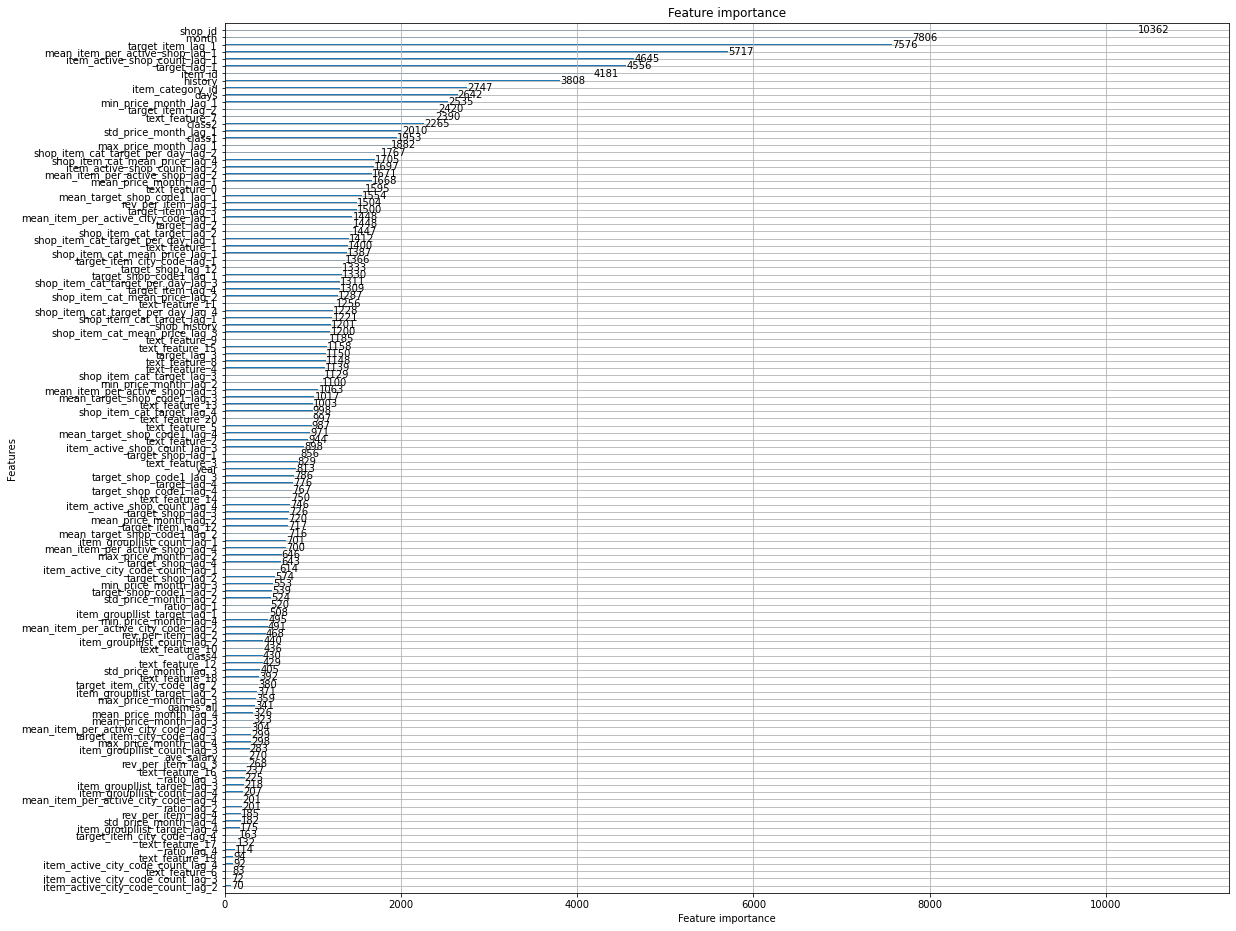

(4,
 0.7730681947992484,
 0.8618510970219994,
 <lightgbm.basic.Booster at 0x7fc91b5739e8>)

In [52]:
 #duct_tape
gc.collect() 

params = {
    'objective': 'mse',
    'metric': 'rmse',
    #'num_leaves': 2 ** 7 - 1,
    'device': 'gpu',
    'learning_rate': 0.004,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    #'lambda_l1':  1.4166324207094624e-08,
    #'lambda_l2':   0.0002214880864217134,
    'bagging_freq': 1,
    'seed': 1,
    'verbose': 1,
    'num_iterations': 5000, 
     'early_stopping_round': 200,
     'cat_l2' :16
}         
lgb_val_rmse(X_train, y_train, X_val, y_val ,params,M )

In [54]:
print(model.feature_importance())

NameError: ignored

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18787
[LightGBM] [Info] Number of data points in the train set: 9155520, number of used features: 128
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (558.81 MB) transferred to GPU in 0.472156 secs. 1 sparse feature groups


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.295531
Training until validation scores don't improve for 200 rounds
[10]	training's rmse: 1.19798	valid_1's rmse: 1.12132
[20]	training's rmse: 1.18004	valid_1's rmse: 1.10667
[30]	training's rmse: 1.16322	valid_1's rmse: 1.09342
[40]	training's rmse: 1.14699	valid_1's rmse: 1.08042
[50]	training's rmse: 1.1315	valid_1's rmse: 1.06817
[60]	training's rmse: 1.11736	valid_1's rmse: 1.05715
[70]	training's rmse: 1.10383	valid_1's rmse: 1.04655
[80]	training's rmse: 1.09069	valid_1's rmse: 1.03645
[90]	training's rmse: 1.07857	valid_1's rmse: 1.02702
[100]	training's rmse: 1.06743	valid_1's rmse: 1.01869
[110]	training's rmse: 1.05671	valid_1's rmse: 1.01077
[120]	training's rmse: 1.04659	valid_1's rmse: 1.00327
[130]	training's rmse: 1.03685	valid_1's rmse: 0.996225
[140]	training's rmse: 1.02775	valid_1's rmse: 0.989637
[150]	training's rmse: 1.01887	valid_1's rmse: 0.983248
[160]	training's rmse: 1.01068	valid_1's rmse: 0.97736
[170]	traini

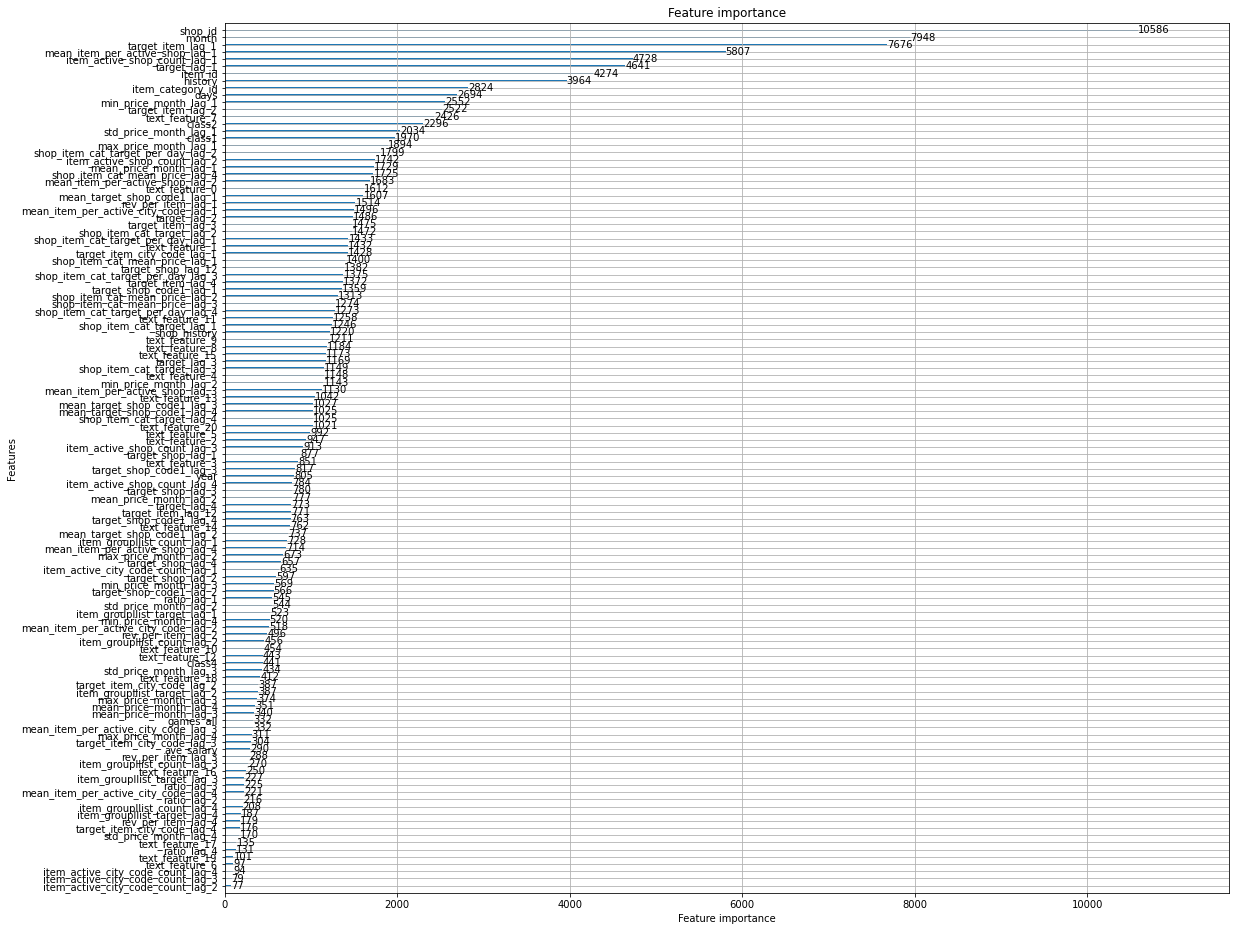

In [55]:
gc.collect()  

params = {
    'objective': 'mse',
    'metric': 'rmse',
    #'num_leaves': 2 ** 7 - 1,
    'device': 'gpu',
    'learning_rate': 0.004,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    #'lambda_l1':  1.4166324207094624e-08,
    #'lambda_l2':   0.0002214880864217134,
    'bagging_freq': 1,
    'seed': 1,
    'verbose': 1,
    'num_iterations':  8000, 
     'early_stopping_round': 200,
     'cat_l2' :16
}         
M_,t_rmse,v_rmse, model=lgb_val_rmse(X_train, y_train, X_val, y_val ,params,M )

In [56]:
gc.collect()
print(len(X_val.columns),X_val.columns.values)

128 ['shop_id' 'item_id' 'min_price_month_lag_1' 'rev_per_item_lag_1'
 'max_price_month_lag_1' 'std_price_month_lag_1' 'mean_price_month_lag_1'
 'shop_rev_lag_1' 'target_lag_1' 'min_price_month_lag_2'
 'rev_per_item_lag_2' 'max_price_month_lag_2' 'std_price_month_lag_2'
 'mean_price_month_lag_2' 'shop_rev_lag_2' 'target_lag_2'
 'min_price_month_lag_3' 'rev_per_item_lag_3' 'max_price_month_lag_3'
 'std_price_month_lag_3' 'mean_price_month_lag_3' 'shop_rev_lag_3'
 'target_lag_3' 'min_price_month_lag_4' 'rev_per_item_lag_4'
 'max_price_month_lag_4' 'std_price_month_lag_4' 'mean_price_month_lag_4'
 'shop_rev_lag_4' 'target_lag_4' 'shop_history' 'ave_salary'
 'item_groupllist_count_lag_1' 'item_groupllist_target_lag_1'
 'ratio_lag_1' 'item_groupllist_count_lag_2'
 'item_groupllist_target_lag_2' 'ratio_lag_2'
 'item_groupllist_count_lag_3' 'item_groupllist_target_lag_3'
 'ratio_lag_3' 'item_groupllist_count_lag_4'
 'item_groupllist_target_lag_4' 'ratio_lag_4' 'item_category_id'
 'shop_item_c

In [57]:
#K=features to keep
K=120

print(model.feature_importance())
print(list(model.feature_importance() ))
features_by_importance=list(zip(X_train.columns,model.feature_importance()))

print('features_by_importance',len(features_by_importance ) ,features_by_importance )

features_by_importance=pd.DataFrame(features_by_importance)
sorted_features_by_importance=features_by_importance.sort_values(by=[1],ascending =False )

print(sorted_features_by_importance)
leftover_features=list(sorted_features_by_importance[K:][0].values)
if 'date_block_num' in leftover_features:
  leftover_features.drop('date_block_num')

print(   leftover_features )
 





[10586  4274  2552  1514  1894  2034  1729     1  4641  1143   496   673
   544   777     0  1486   569   288   374   434   340     0  1169   520
   179   311   170   351     0   773  1220   290   728   523   545   456
   387   216   270   227   225   208   187   131  2824  1433  1400  1246
  1799  1313  1472  1375  1274  1149  1273  1725  1025  1496   635  1428
   518    77   387   332    79   304   221    94   176  4728  5807  7676
  1742  1683  2522   913  1130  1475   784   714  1372   771  3964  1607
    20  1359   737    52   566  1027    62   817  1025    64   763  2694
   877   597   780   657  1382  7948   805   332  1970  2296   441  1612
  1432   947   851  1148   992    97  2426  1184  1211   454  1258   443
  1042   762  1173   250   135   412   101  1021]
[10586, 4274, 2552, 1514, 1894, 2034, 1729, 1, 4641, 1143, 496, 673, 544, 777, 0, 1486, 569, 288, 374, 434, 340, 0, 1169, 520, 179, 311, 170, 351, 0, 773, 1220, 290, 728, 523, 545, 456, 387, 216, 270, 227, 225, 208, 187,

In [58]:
print(grid1.columns.values)

NameError: ignored

In [ ]:
grid1=grid1.drop(leftover_features ,axis=1)
print(grid1.columns.values)
#text_features_select=[x for x in  grid1.columns.values if 'text' in x]
print(len(text_features_select),text_features_select)
#text_features_select=['text_feature_0', 'text_feature_1', 'text_feature_2', 'text_feature_3', 'text_feature_4', 'text_feature_5', 'text_feature_7', 'text_feature_8', 'text_feature_9', 'text_feature_10', 'text_feature_11', 'text_feature_13', 'text_feature_14', 'text_feature_15', 'text_feature_20']

In [62]:
#print(grid1.shape)
print(X_train.shape)
print(X_test.shape)
X_test=X_test.drop(leftover_features ,axis=1)
X_val=X_val.drop(leftover_features ,axis=1) 
X_train=X_train.drop(leftover_features ,axis=1) 
X_train32=X_train32.drop(leftover_features ,axis=1) 
print(X_train.shape)
print(X_test.shape)

(9155520, 128)
(214200, 120)
(214200, 120)
(214200, 120)


In [ ]:
  
 
X_train, y_train, X_val, y_val= lgm_from_month_M_sets(grid1,M,to_drop_cols,remove_shop_36_in_validation=True)
print(X_val.loc[X_val.date_block_num==33,'shop_id'].value_counts())
print(X_val.loc[X_val.date_block_num==33,'shop_id'].nunique())

In [65]:
gc.collect()
params = { 
    'objective': 'mse',
    'metric': 'rmse',
    #'num_leaves': 2 ** 7 - 1,
    'device': 'gpu',
    'learning_rate': 0.004,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    #'lambda_l1':  1.4166324207094624e-08,
    #'lambda_l2':   0.0002214880864217134,
    'bagging_freq': 1,
    'seed': 1,
    'verbose': 1,
    'num_iterations':  8000, 
     'early_stopping_round': 200,
     'cat_l2' :16
}         
M_,t_rmse,v_rmse, model_r=lgb_val_rmse(X_train, y_train, X_val, y_val ,params,M )

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18771
[LightGBM] [Info] Number of data points in the train set: 9155520, number of used features: 120
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (523.88 MB) transferred to GPU in 0.440732 secs. 1 sparse feature groups


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.295531
Training until validation scores don't improve for 200 rounds
[10]	training's rmse: 1.19764	valid_1's rmse: 1.121
[20]	training's rmse: 1.17968	valid_1's rmse: 1.10646
[30]	training's rmse: 1.16272	valid_1's rmse: 1.09296
[40]	training's rmse: 1.14641	valid_1's rmse: 1.08009
[50]	training's rmse: 1.13108	valid_1's rmse: 1.06804
[60]	training's rmse: 1.11693	valid_1's rmse: 1.05723
[70]	training's rmse: 1.10308	valid_1's rmse: 1.04625
[80]	training's rmse: 1.09011	valid_1's rmse: 1.03635
[90]	training's rmse: 1.07781	valid_1's rmse: 1.02693
[100]	training's rmse: 1.06645	valid_1's rmse: 1.01846
[110]	training's rmse: 1.05551	valid_1's rmse: 1.01031
[120]	training's rmse: 1.04545	valid_1's rmse: 1.00282
[130]	training's rmse: 1.03595	valid_1's rmse: 0.995863
[140]	training's rmse: 1.02682	valid_1's rmse: 0.98918
[150]	training's rmse: 1.01831	valid_1's rmse: 0.98292
[160]	training's rmse: 1.01014	valid_1's rmse: 0.976942
[170]	training

LightGBMError: ignored

In [ ]:
STOP HERE!


2


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.948602	valid_1's rmse: 0.937298
[20]	training's rmse: 0.881604	valid_1's rmse: 0.898775
[30]	training's rmse: 0.857319	valid_1's rmse: 0.888707
[40]	training's rmse: 0.844098	valid_1's rmse: 0.884996
[50]	training's rmse: 0.835336	valid_1's rmse: 0.882935
[60]	training's rmse: 0.828586	valid_1's rmse: 0.880961
[70]	training's rmse: 0.823365	valid_1's rmse: 0.879744
[80]	training's rmse: 0.818221	valid_1's rmse: 0.876942
[90]	training's rmse: 0.813966	valid_1's rmse: 0.878526
[100]	training's rmse: 0.810423	valid_1's rmse: 0.877883
[110]	training's rmse: 0.80624	valid_1's rmse: 0.877688
[120]	training's rmse: 0.802748	valid_1's rmse: 0.877316
[130]	training's rmse: 0.800109	valid_1's rmse: 0.876581
[140]	training's rmse: 0.797436	valid_1's rmse: 0.87682
[150]	training's rmse: 0.795307	valid_1's rmse: 0.87565
[160]	training's rmse: 0.793155	valid_1's rmse: 0.874995
[170]	training's rmse: 0.79042	valid_1

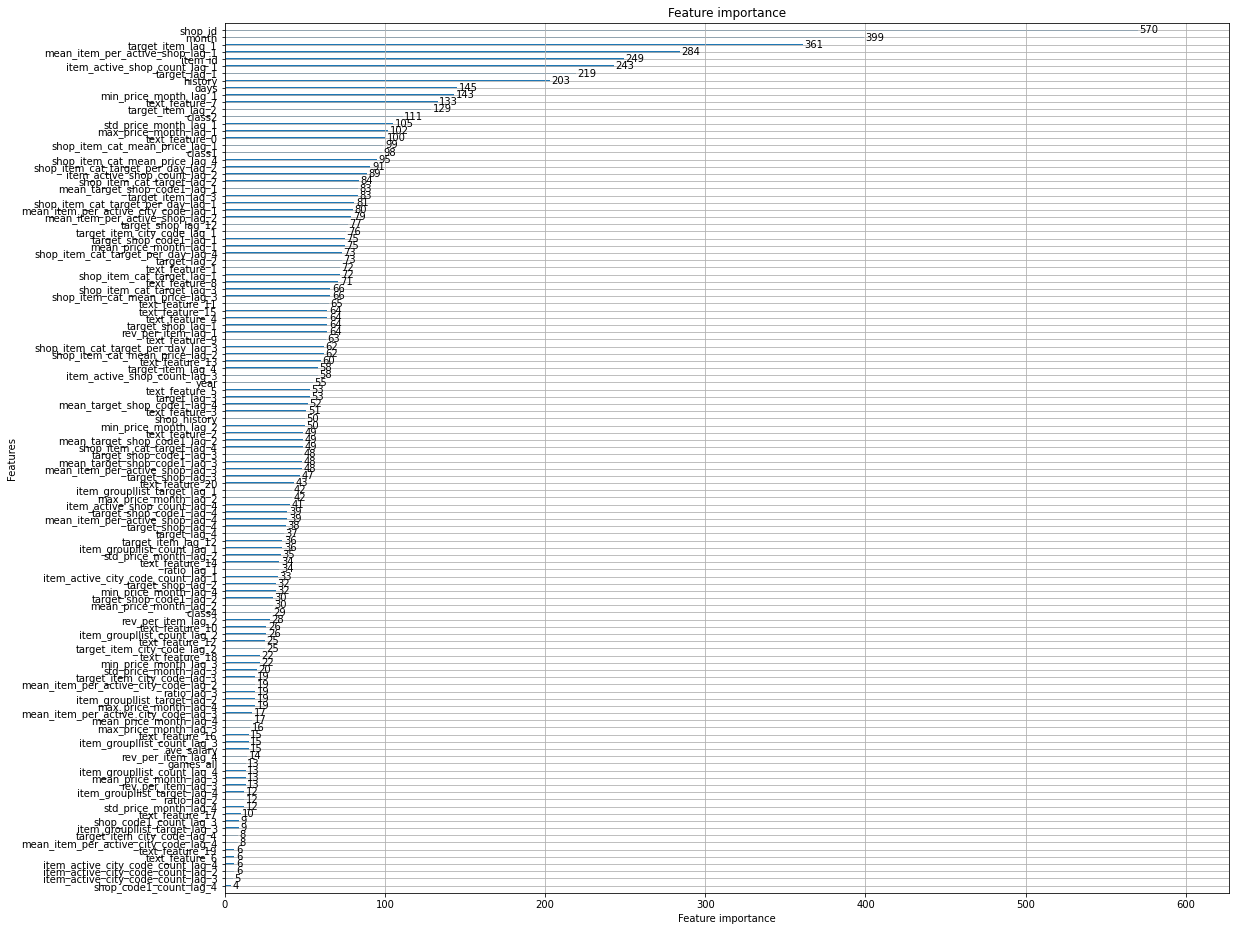

4


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.948636	valid_1's rmse: 0.937319
[20]	training's rmse: 0.881672	valid_1's rmse: 0.898803
[30]	training's rmse: 0.857404	valid_1's rmse: 0.88843
[40]	training's rmse: 0.844951	valid_1's rmse: 0.886379
[50]	training's rmse: 0.836097	valid_1's rmse: 0.882907
[60]	training's rmse: 0.82997	valid_1's rmse: 0.880562
[70]	training's rmse: 0.823856	valid_1's rmse: 0.878417
[80]	training's rmse: 0.818682	valid_1's rmse: 0.877415
[90]	training's rmse: 0.814316	valid_1's rmse: 0.879103
[100]	training's rmse: 0.810159	valid_1's rmse: 0.880086
[110]	training's rmse: 0.807274	valid_1's rmse: 0.875788
[120]	training's rmse: 0.804635	valid_1's rmse: 0.8729
[130]	training's rmse: 0.802111	valid_1's rmse: 0.872642
[140]	training's rmse: 0.798777	valid_1's rmse: 0.872342
[150]	training's rmse: 0.796043	valid_1's rmse: 0.870383
[160]	training's rmse: 0.79358	valid_1's rmse: 0.868629
[170]	training's rmse: 0.791661	valid_1'

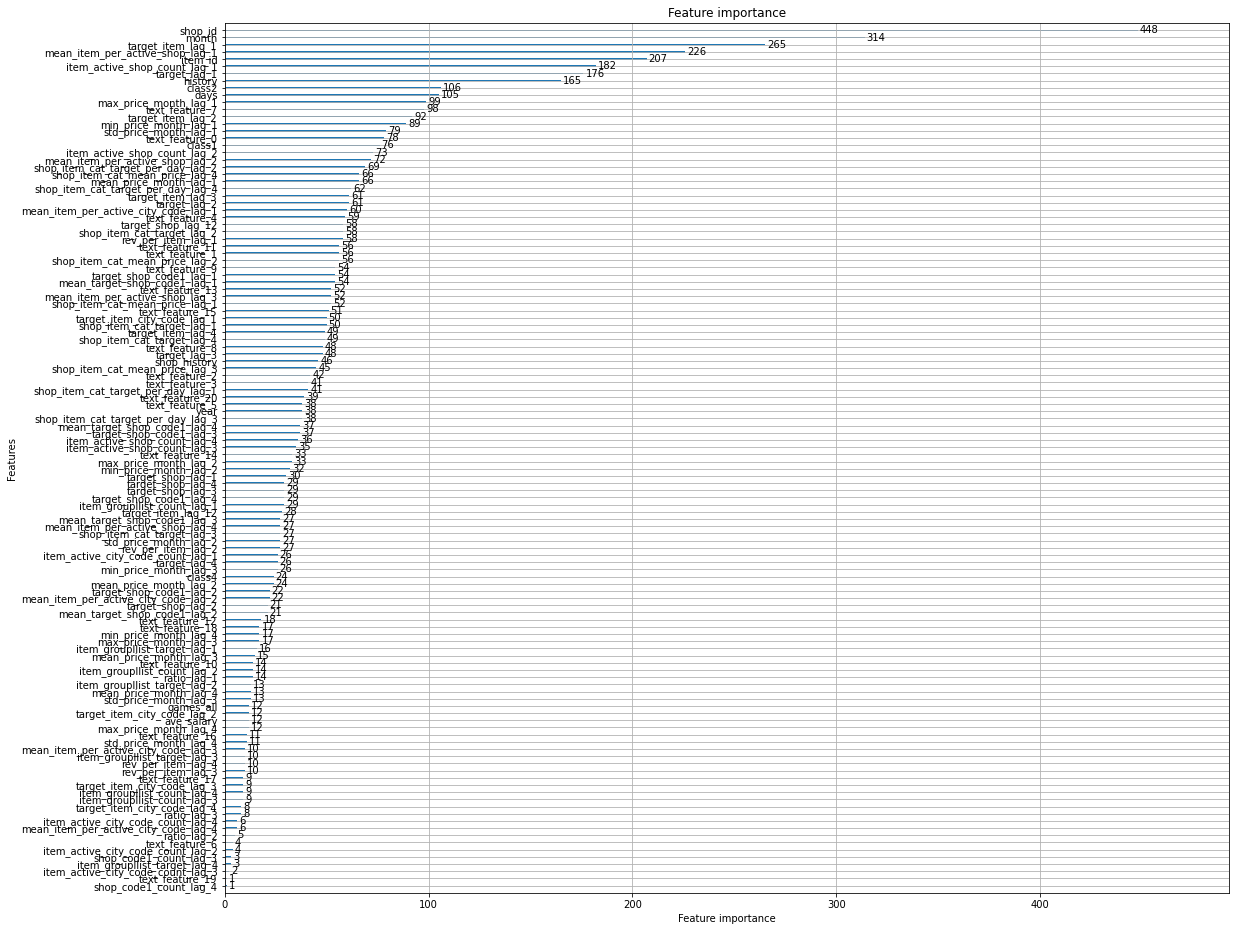

6


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.948738	valid_1's rmse: 0.937417
[20]	training's rmse: 0.881418	valid_1's rmse: 0.898255
[30]	training's rmse: 0.857478	valid_1's rmse: 0.88706
[40]	training's rmse: 0.844692	valid_1's rmse: 0.884199
[50]	training's rmse: 0.83628	valid_1's rmse: 0.880909
[60]	training's rmse: 0.828894	valid_1's rmse: 0.876686
[70]	training's rmse: 0.823614	valid_1's rmse: 0.872151
[80]	training's rmse: 0.818482	valid_1's rmse: 0.871722
[90]	training's rmse: 0.813936	valid_1's rmse: 0.872683
[100]	training's rmse: 0.810729	valid_1's rmse: 0.872183
[110]	training's rmse: 0.806635	valid_1's rmse: 0.871596
[120]	training's rmse: 0.804121	valid_1's rmse: 0.871315
[130]	training's rmse: 0.801499	valid_1's rmse: 0.872017
[140]	training's rmse: 0.799273	valid_1's rmse: 0.872477
[150]	training's rmse: 0.797048	valid_1's rmse: 0.872023
[160]	training's rmse: 0.794821	valid_1's rmse: 0.87182
[170]	training's rmse: 0.792266	valid_

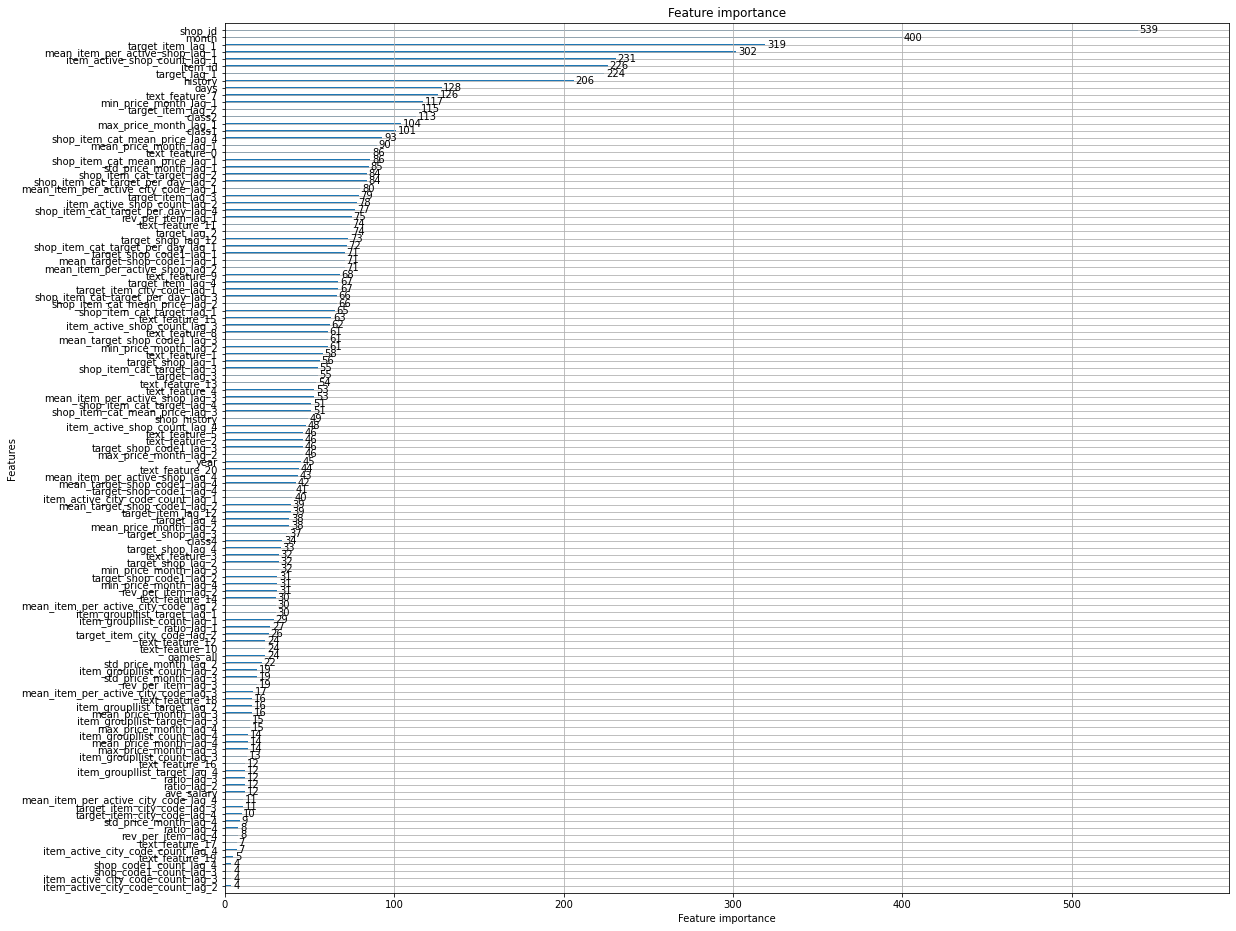

8


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.949309	valid_1's rmse: 0.938408
[20]	training's rmse: 0.882277	valid_1's rmse: 0.898671
[30]	training's rmse: 0.859622	valid_1's rmse: 0.889116
[40]	training's rmse: 0.846386	valid_1's rmse: 0.884962
[50]	training's rmse: 0.837028	valid_1's rmse: 0.881707
[60]	training's rmse: 0.830515	valid_1's rmse: 0.881226
[70]	training's rmse: 0.823857	valid_1's rmse: 0.879346
[80]	training's rmse: 0.818527	valid_1's rmse: 0.880905
[90]	training's rmse: 0.814322	valid_1's rmse: 0.880007
[100]	training's rmse: 0.810804	valid_1's rmse: 0.875325
[110]	training's rmse: 0.807931	valid_1's rmse: 0.873346
[120]	training's rmse: 0.804189	valid_1's rmse: 0.873339
[130]	training's rmse: 0.801312	valid_1's rmse: 0.87118
[140]	training's rmse: 0.798894	valid_1's rmse: 0.869982
[150]	training's rmse: 0.797146	valid_1's rmse: 0.869476
[160]	training's rmse: 0.795227	valid_1's rmse: 0.869926
[170]	training's rmse: 0.793002	vali

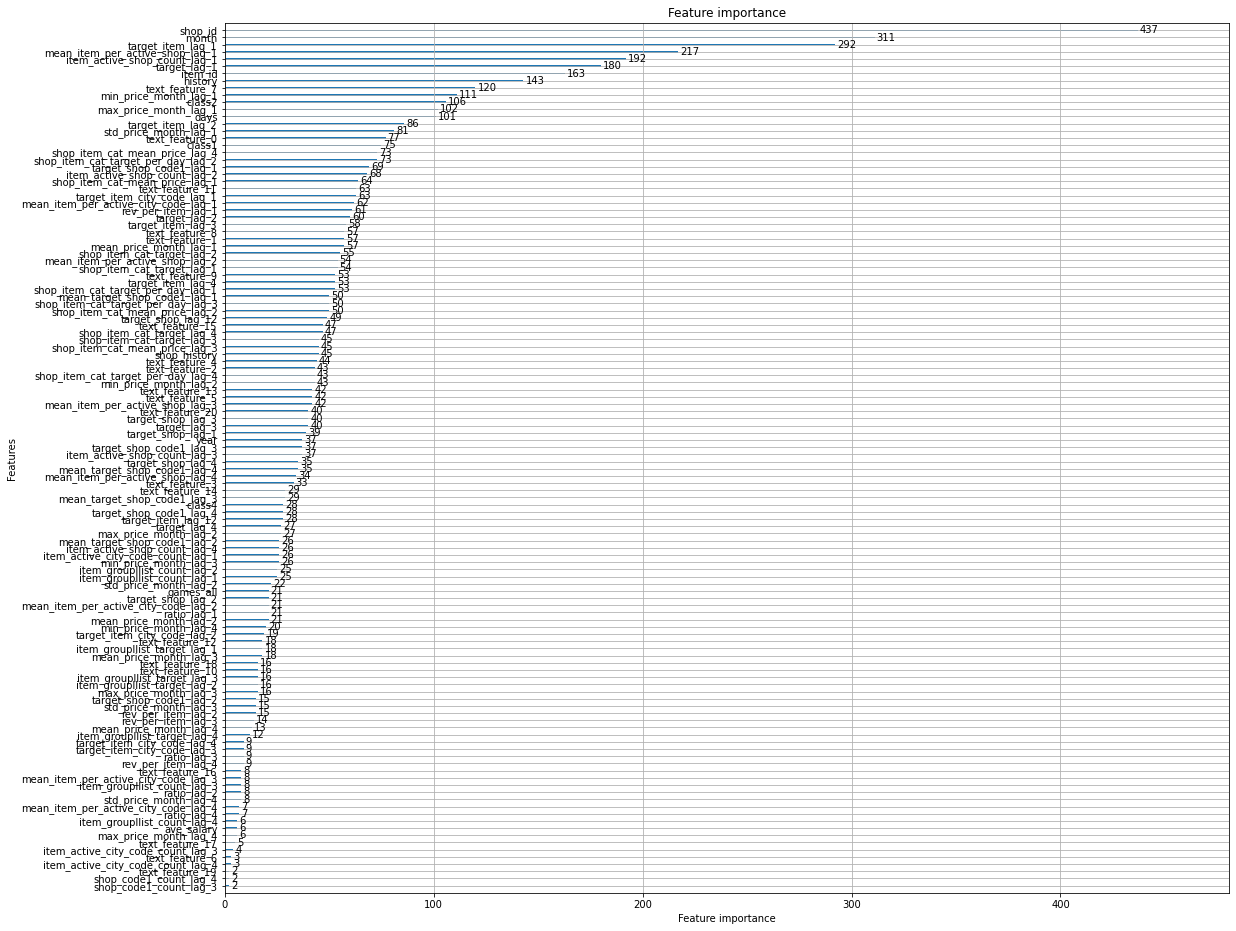

10


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.948706	valid_1's rmse: 0.936741
[20]	training's rmse: 0.882102	valid_1's rmse: 0.898787
[30]	training's rmse: 0.858762	valid_1's rmse: 0.887337
[40]	training's rmse: 0.845672	valid_1's rmse: 0.882549
[50]	training's rmse: 0.836474	valid_1's rmse: 0.879681
[60]	training's rmse: 0.830312	valid_1's rmse: 0.877593
[70]	training's rmse: 0.823407	valid_1's rmse: 0.873796
[80]	training's rmse: 0.819008	valid_1's rmse: 0.871892
[90]	training's rmse: 0.814485	valid_1's rmse: 0.872853
[100]	training's rmse: 0.811278	valid_1's rmse: 0.872751
[110]	training's rmse: 0.807935	valid_1's rmse: 0.871957
[120]	training's rmse: 0.80504	valid_1's rmse: 0.871594
[130]	training's rmse: 0.802507	valid_1's rmse: 0.870376
[140]	training's rmse: 0.799886	valid_1's rmse: 0.86979
[150]	training's rmse: 0.797581	valid_1's rmse: 0.866771
[160]	training's rmse: 0.795509	valid_1's rmse: 0.866418
[170]	training's rmse: 0.793271	valid

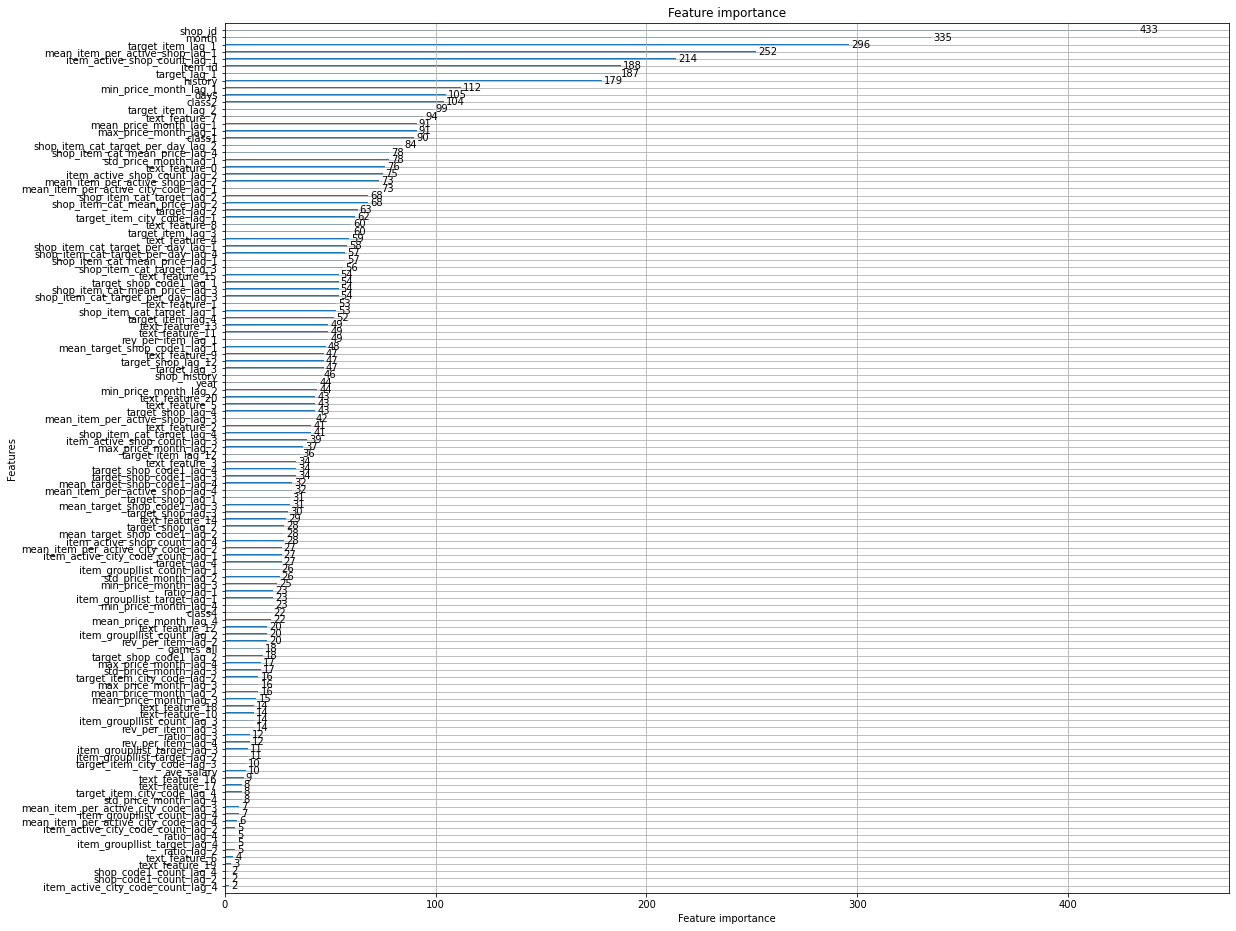

12


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.94873	valid_1's rmse: 0.936761
[20]	training's rmse: 0.881873	valid_1's rmse: 0.898598
[30]	training's rmse: 0.858295	valid_1's rmse: 0.887499
[40]	training's rmse: 0.845437	valid_1's rmse: 0.883864
[50]	training's rmse: 0.837374	valid_1's rmse: 0.881919
[60]	training's rmse: 0.830578	valid_1's rmse: 0.881258
[70]	training's rmse: 0.824307	valid_1's rmse: 0.880048
[80]	training's rmse: 0.819304	valid_1's rmse: 0.878261
[90]	training's rmse: 0.815035	valid_1's rmse: 0.876887
[100]	training's rmse: 0.810916	valid_1's rmse: 0.876495
[110]	training's rmse: 0.807892	valid_1's rmse: 0.875823
[120]	training's rmse: 0.804527	valid_1's rmse: 0.875955
[130]	training's rmse: 0.801417	valid_1's rmse: 0.873639
[140]	training's rmse: 0.799066	valid_1's rmse: 0.872957
[150]	training's rmse: 0.796712	valid_1's rmse: 0.869462
[160]	training's rmse: 0.794342	valid_1's rmse: 0.868273
[170]	training's rmse: 0.792203	vali

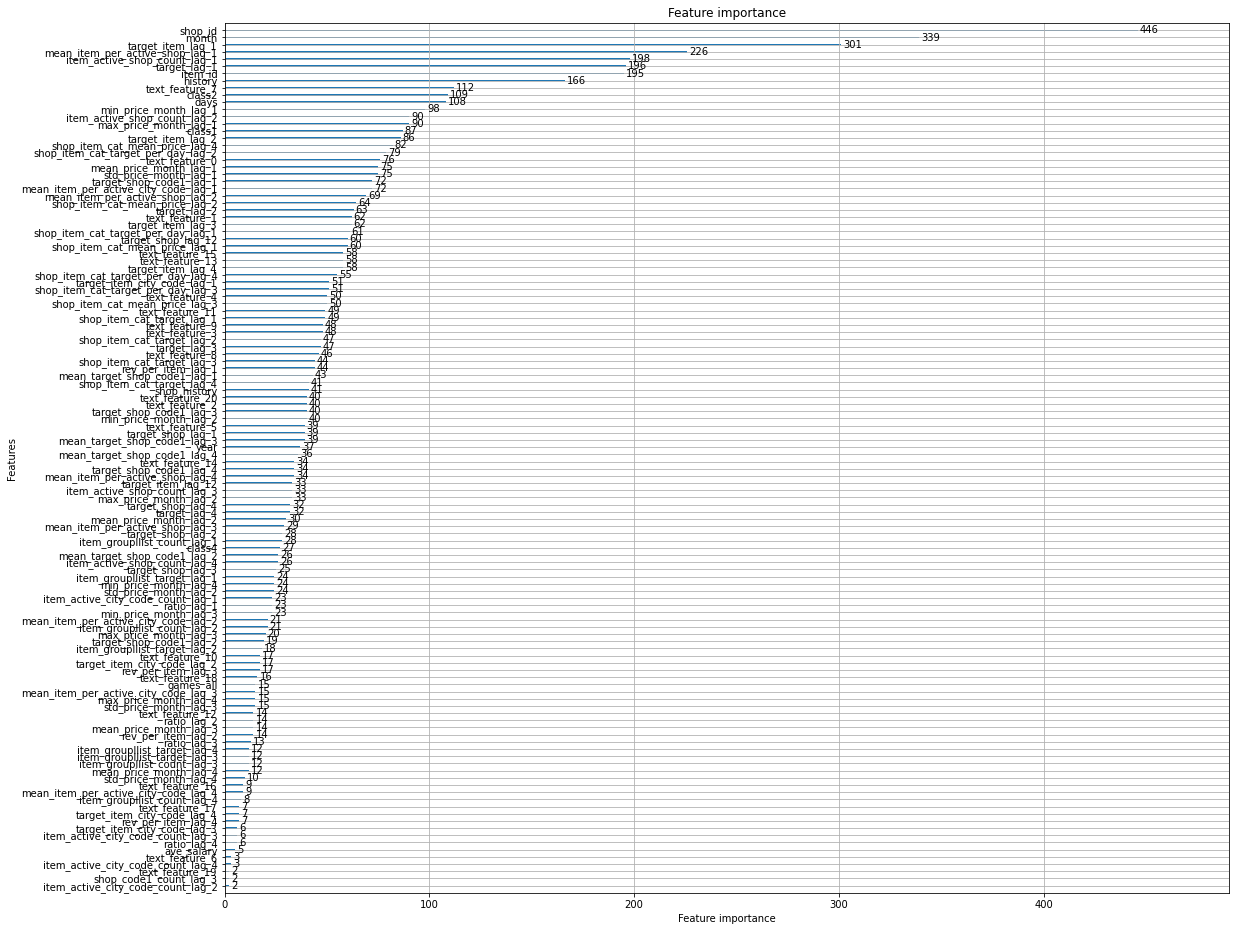

14


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.94875	valid_1's rmse: 0.936864
[20]	training's rmse: 0.881595	valid_1's rmse: 0.898755
[30]	training's rmse: 0.858296	valid_1's rmse: 0.888779
[40]	training's rmse: 0.845606	valid_1's rmse: 0.886797
[50]	training's rmse: 0.836757	valid_1's rmse: 0.882552
[60]	training's rmse: 0.829378	valid_1's rmse: 0.880251
[70]	training's rmse: 0.82331	valid_1's rmse: 0.88083
[80]	training's rmse: 0.818339	valid_1's rmse: 0.878994
[90]	training's rmse: 0.814311	valid_1's rmse: 0.878046
[100]	training's rmse: 0.81065	valid_1's rmse: 0.875555
[110]	training's rmse: 0.807591	valid_1's rmse: 0.874129
[120]	training's rmse: 0.804252	valid_1's rmse: 0.87421
[130]	training's rmse: 0.801821	valid_1's rmse: 0.871887
[140]	training's rmse: 0.799468	valid_1's rmse: 0.870953
[150]	training's rmse: 0.797696	valid_1's rmse: 0.870656
[160]	training's rmse: 0.794991	valid_1's rmse: 0.871245
[170]	training's rmse: 0.792317	valid_1'

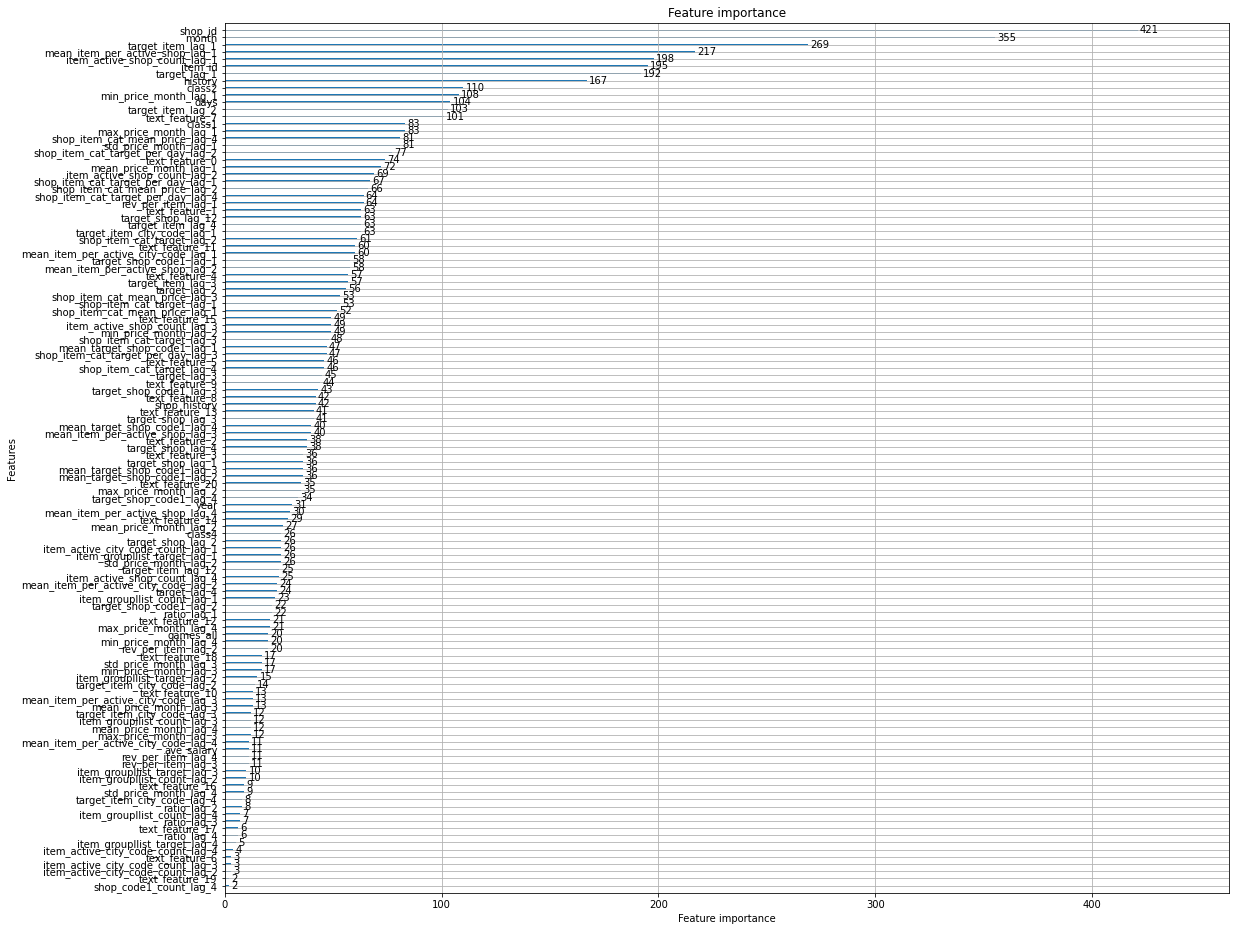

16


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.94877	valid_1's rmse: 0.936884
[20]	training's rmse: 0.88137	valid_1's rmse: 0.898633
[30]	training's rmse: 0.857758	valid_1's rmse: 0.886806
[40]	training's rmse: 0.845493	valid_1's rmse: 0.884018
[50]	training's rmse: 0.836331	valid_1's rmse: 0.880721
[60]	training's rmse: 0.83046	valid_1's rmse: 0.876242
[70]	training's rmse: 0.824727	valid_1's rmse: 0.874367
[80]	training's rmse: 0.819539	valid_1's rmse: 0.871774
[90]	training's rmse: 0.815486	valid_1's rmse: 0.87032
[100]	training's rmse: 0.811539	valid_1's rmse: 0.871581
[110]	training's rmse: 0.808027	valid_1's rmse: 0.873806
[120]	training's rmse: 0.805391	valid_1's rmse: 0.874693
[130]	training's rmse: 0.803307	valid_1's rmse: 0.874705
[140]	training's rmse: 0.800157	valid_1's rmse: 0.874352
[150]	training's rmse: 0.797736	valid_1's rmse: 0.870724
[160]	training's rmse: 0.795155	valid_1's rmse: 0.869989
[170]	training's rmse: 0.793189	valid_1

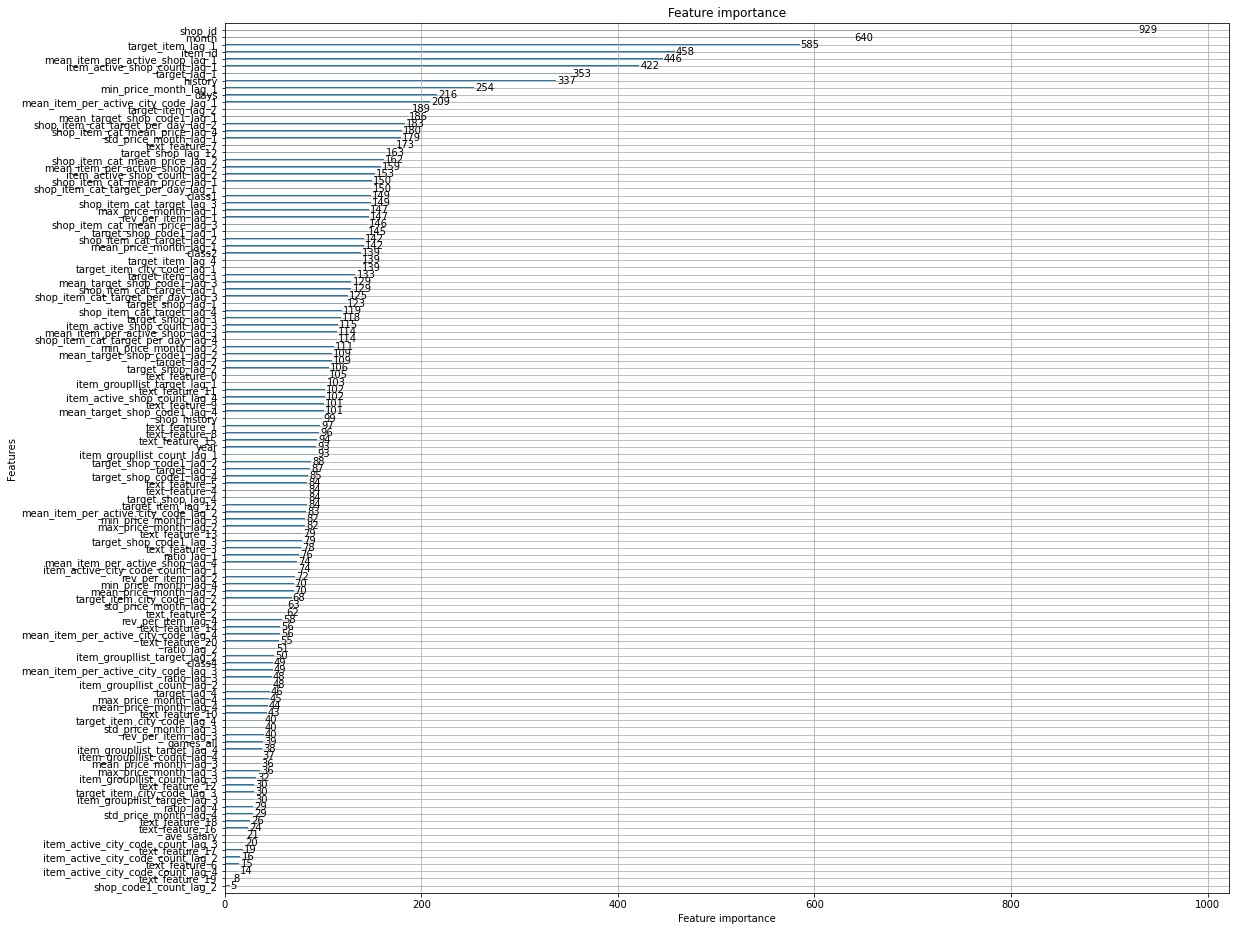

18


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.948791	valid_1's rmse: 0.936904
[20]	training's rmse: 0.881413	valid_1's rmse: 0.89866
[30]	training's rmse: 0.858598	valid_1's rmse: 0.88592
[40]	training's rmse: 0.845887	valid_1's rmse: 0.881795
[50]	training's rmse: 0.837564	valid_1's rmse: 0.880561
[60]	training's rmse: 0.83055	valid_1's rmse: 0.880511
[70]	training's rmse: 0.824553	valid_1's rmse: 0.877405
[80]	training's rmse: 0.819212	valid_1's rmse: 0.874344
[90]	training's rmse: 0.81499	valid_1's rmse: 0.872995
[100]	training's rmse: 0.811205	valid_1's rmse: 0.872849
[110]	training's rmse: 0.808209	valid_1's rmse: 0.871476
[120]	training's rmse: 0.804911	valid_1's rmse: 0.872638
[130]	training's rmse: 0.80176	valid_1's rmse: 0.869149
[140]	training's rmse: 0.799287	valid_1's rmse: 0.868786
[150]	training's rmse: 0.797035	valid_1's rmse: 0.868415
[160]	training's rmse: 0.794877	valid_1's rmse: 0.864756
[170]	training's rmse: 0.793435	valid_1'

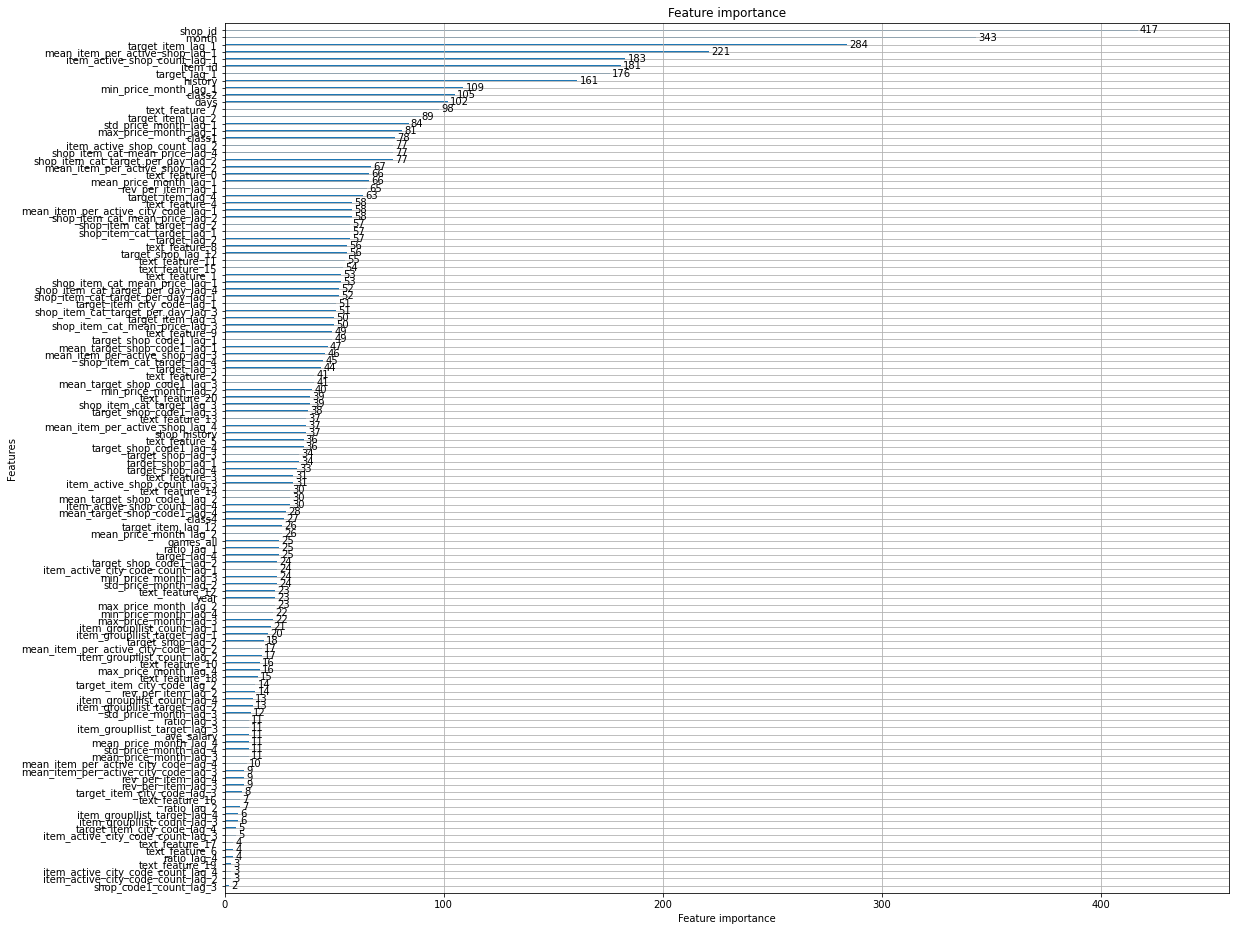

20


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.94901	valid_1's rmse: 0.937049
[20]	training's rmse: 0.881864	valid_1's rmse: 0.898635
[30]	training's rmse: 0.858191	valid_1's rmse: 0.888142
[40]	training's rmse: 0.845557	valid_1's rmse: 0.884454
[50]	training's rmse: 0.836925	valid_1's rmse: 0.881972
[60]	training's rmse: 0.830381	valid_1's rmse: 0.8781
[70]	training's rmse: 0.824722	valid_1's rmse: 0.876798
[80]	training's rmse: 0.819848	valid_1's rmse: 0.877927
[90]	training's rmse: 0.815484	valid_1's rmse: 0.879015
[100]	training's rmse: 0.812015	valid_1's rmse: 0.878913
[110]	training's rmse: 0.808573	valid_1's rmse: 0.879433
[120]	training's rmse: 0.804639	valid_1's rmse: 0.876803
[130]	training's rmse: 0.80255	valid_1's rmse: 0.876694
[140]	training's rmse: 0.800455	valid_1's rmse: 0.876133
[150]	training's rmse: 0.797897	valid_1's rmse: 0.872774
[160]	training's rmse: 0.796188	valid_1's rmse: 0.872256
[170]	training's rmse: 0.793215	valid_1

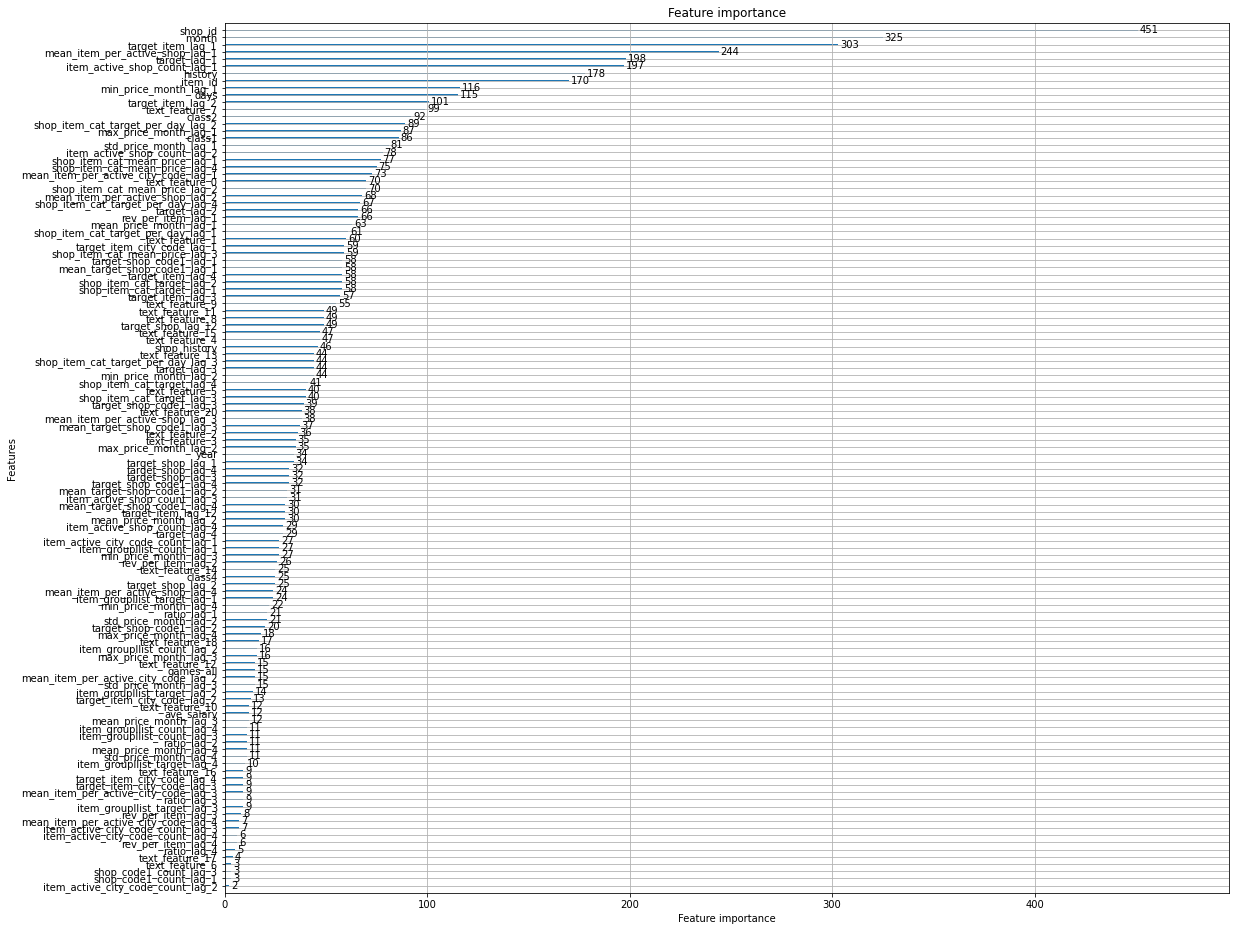

22


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.949035	valid_1's rmse: 0.937067
[20]	training's rmse: 0.881766	valid_1's rmse: 0.898057
[30]	training's rmse: 0.859015	valid_1's rmse: 0.888084
[40]	training's rmse: 0.845683	valid_1's rmse: 0.883653
[50]	training's rmse: 0.837392	valid_1's rmse: 0.882154
[60]	training's rmse: 0.830263	valid_1's rmse: 0.88184
[70]	training's rmse: 0.823648	valid_1's rmse: 0.883517
[80]	training's rmse: 0.818719	valid_1's rmse: 0.880108
[90]	training's rmse: 0.814371	valid_1's rmse: 0.878555
[100]	training's rmse: 0.811215	valid_1's rmse: 0.877698
[110]	training's rmse: 0.808154	valid_1's rmse: 0.875915
[120]	training's rmse: 0.804343	valid_1's rmse: 0.87723
[130]	training's rmse: 0.802058	valid_1's rmse: 0.876488
[140]	training's rmse: 0.799115	valid_1's rmse: 0.875241
[150]	training's rmse: 0.796895	valid_1's rmse: 0.87444
[160]	training's rmse: 0.795219	valid_1's rmse: 0.874
[170]	training's rmse: 0.793267	valid_1's

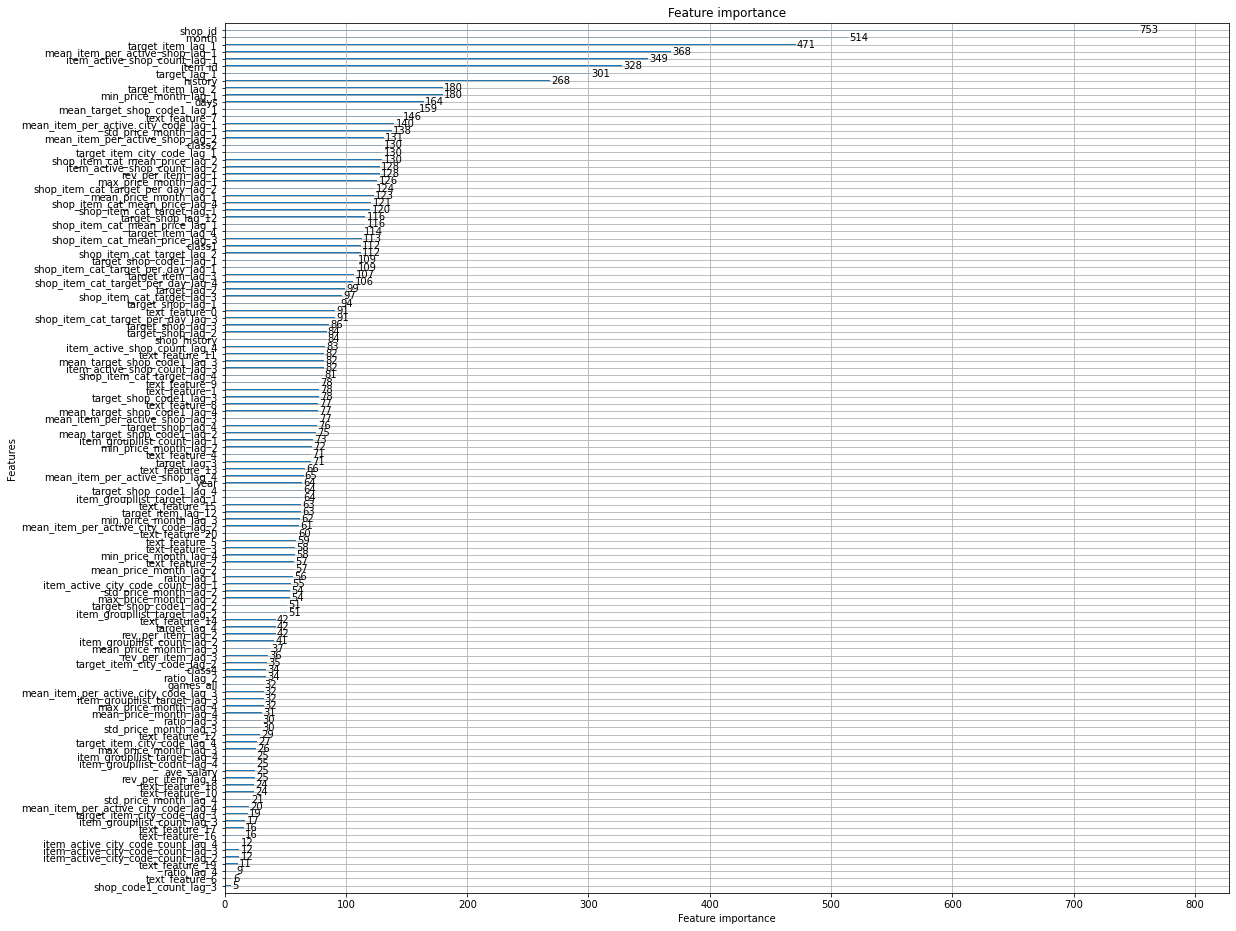

24


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.949511	valid_1's rmse: 0.9381
[20]	training's rmse: 0.88212	valid_1's rmse: 0.898758
[30]	training's rmse: 0.858172	valid_1's rmse: 0.888917
[40]	training's rmse: 0.845335	valid_1's rmse: 0.884122
[50]	training's rmse: 0.836452	valid_1's rmse: 0.882781
[60]	training's rmse: 0.830326	valid_1's rmse: 0.881948
[70]	training's rmse: 0.824744	valid_1's rmse: 0.880284
[80]	training's rmse: 0.820807	valid_1's rmse: 0.878198
[90]	training's rmse: 0.815705	valid_1's rmse: 0.879493
[100]	training's rmse: 0.812109	valid_1's rmse: 0.878144
[110]	training's rmse: 0.807706	valid_1's rmse: 0.877497
[120]	training's rmse: 0.804445	valid_1's rmse: 0.874497
[130]	training's rmse: 0.801873	valid_1's rmse: 0.871572
[140]	training's rmse: 0.79885	valid_1's rmse: 0.871121
[150]	training's rmse: 0.796561	valid_1's rmse: 0.870572
[160]	training's rmse: 0.794931	valid_1's rmse: 0.869353
[170]	training's rmse: 0.792681	valid_1

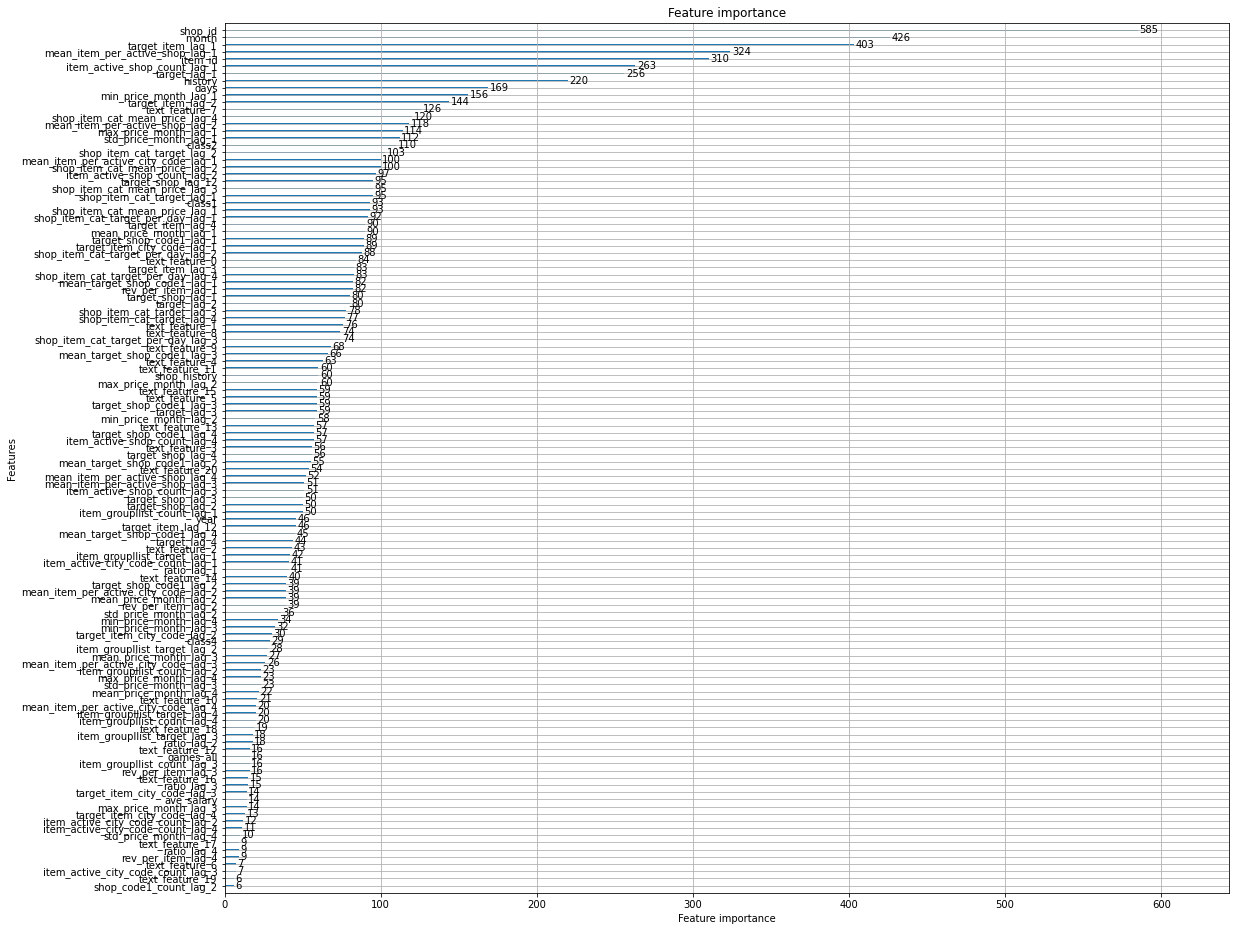

In [182]:
for l2_reg in range(2,26,2):
  params= {'objective': 'mse', 
         'metric': 'rmse', 
         'device': 'gpu',
         'verbosity': -1, 
         #'boosting_type': 'gbdt', 
         #'feature_pre_filter': 'false', 
         #'lambda_l1': 1.4166324207094624e-08,
         #'lambda_l2': 0.0002214880864217134,
         #'num_leaves': 32, 
         'feature_fraction': 0.7, 
         'bagging_fraction':.7, #0.9996780998220467, 
         'bagging_freq': 1,
         #'min_child_samples': 100, 
         'num_iterations': 5000, 
         'early_stopping_round': 100,
         'seed' : 42,
         'cat_l2' :l2_reg
         }
  print(l2_reg)       
  lgb_val_rmse(X_train, y_train, X_val, y_val ,params,M )

###the above code works!


In [ ]:
#Validation for every M from 12 to 30:
#[(12, 0.7589448396948913, 0.8023121020692328), (13, 0.7153507086334678, 0.800696189237234), (14, 0.7306193951532918, 0.7984914768821185), (15, 0.7407010980695012, 0.7996161564308236), (16, 0.7296444329518996, 0.8037359721542265),
# (17, 0.7192353412614186, 0.8062449481634244), (18, 0.7704201929781149, 0.8159857845582448), (19, 0.7662722152613644, 0.8099982989057865), (20, 0.7428185104767566, 0.8090586174738267), (21, 0.780634732474549, 0.8084287382902978), (22, 0.7656183859683722, 0.8203439667023573), (23, 0.7508332970984621, 0.8190907843255147), (24, 0.7452513475775415, 0.82288947748711), (25, 0.7463854589023281, 0.8231497431519704), (26, 0.7235208638617263, 0.8208556871601159), (27, 0.7049300888039236, 0.8319616960782145), (28, 0.6878005631012818, 0.8336873287221118), (29, 0.6928683817323973, 0.8462499521155267), (30, 0.694456076630667, 0.8422747029721672)] 

out =[(12, 0.7589448396948913, 0.8023121020692328), (13, 0.7153507086334678, 0.800696189237234), (14, 0.7306193951532918, 0.7984914768821185), (15, 0.7407010980695012, 0.7996161564308236), (16, 0.7296444329518996, 0.8037359721542265),
(17, 0.7192353412614186, 0.8062449481634244), (18, 0.7704201929781149, 0.8159857845582448), (19, 0.7662722152613644, 0.8099982989057865), (20, 0.7428185104767566, 0.8090586174738267), (21, 0.780634732474549, 0.8084287382902978), (22, 0.7656183859683722, 0.8203439667023573), (23, 0.7508332970984621, 0.8190907843255147), (24, 0.7452513475775415, 0.82288947748711), (25, 0.7463854589023281, 0.8231497431519704), (26, 0.7235208638617263, 0.8208556871601159), (27, 0.7049300888039236, 0.8319616960782145), (28, 0.6878005631012818, 0.8336873287221118), (29, 0.6928683817323973, 0.8462499521155267), (30, 0.694456076630667, 0.8422747029721672)] 
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

months=[x[0] for x in out]
train=[x[1] for x in out]
valid=[x[2] for x in out]
print(months)
#rs = np.random 
#values = rs.randn(365, 4).cumsum(axis=0)

#dates = pd.date_range("1 1 2016", periods=365, freq="D")
data = pd.DataFrame(data={'months':months,'training': train, 'validation':valid}  )
data['v-t']=data['validation']-data['training']
print(data)

 
sns.lineplot(x='months',y='validation',data =data,  palette="tab10", linewidth=2 ) 


#Good M-values  M=14,15,20,21


### For select m-values run optuna optimization

In [ ]:
!pip install optuna
import optuna.integration.lightgbm as lgb_o
#best_params, tuning_history = dict(), list()
gc.collect()


In [ ]:


params = { "objective": "rmse",
        "metric": "rmse",
        'device' : 'gpu',
        "verbosity": -1,
        "boosting_type": "gbdt",
        "feature_pre_filter" : "false"
    }

#M_list=[15,21] 
M_list=[21] 
for M in M_list:
  X_train, y_train, X_val, y_val= lgm_from_month_M_sets(grid1,M,to_drop_cols )
  lgm_print( X_train, y_train, X_val, y_val, X_test,prn=False)
  lgb_val_rmse(X_train, y_train, X_val, y_val , params,M, mode='lgb_optuna' )
 
 



#best params for M=15: 
(was copied by hand from output. best val values are ~.793 ) 

{'min_child_samples': 100,'lambda_l1': 0.0005361017626350593, 'lambda_l2': 1.1092256617788593e-05,'feature_fraction': 0.6839999999999999, 'bagging_fraction': 0.8124726642058022, 'bagging_freq': 3, 'num_leaves': 41,'feature_fraction': 0.7}

#best params for M=21: 
(was copied by hand from output. best val values are ~.793 ) 
{'min_child_samples': 10,'lambda_l1': 7.149660670534325e-06, 'lambda_l2': 0.029175322307707457,'feature_fraction': 0.6799999999999999,'bagging_fraction': 0.9998569812592093, 'bagging_freq': 4,'num_leaves': 39,'feature_fraction': 0.6}

In [ ]:
 






params = [{ "objective": "rmse",
        "metric": "rmse",
        'device' : 'gpu',
        "verbosity": -1,
        "boosting_type": "gbdt",
        "early_stopping_rounds" : 150,
        "feature_pre_filter" : "false",
        'n_estimators':1000,
        "seed":42,
        #"feature_pre_filter" : "false",
        'min_child_samples': 100,
        'lambda_l1': 0.0005361017626350593, 
        'lambda_l2': 1.1092256617788593e-05,
        'feature_fraction': 0.6839999999999999, 
        'bagging_fraction': 0.8124726642058022, 
        'bagging_freq': 3, 'num_leaves': 41,
        #'feature_fraction': 0.7 
        }, 
        { 'objective': 'rmse', 
          'metric': 'rmse', 
          'device': 'gpu', 
          'verbosity': -1, 
          'boosting_type': 'gbdt', 
          'feature_pre_filter': 'false', 
          'lambda_l1': 2.742693708786352e-08, 
          'lambda_l2': 1.493951002939898e-08, 
          'num_leaves': 31, 
          'feature_fraction': 0.7, 
          'bagging_fraction': 1.0, 
          'bagging_freq': 0, 
          'min_child_samples': 20, 
          'num_iterations': 1000, 
          'early_stopping_round': 100}
        ]

M_list=[15,21] 
 
for i in range(len(M_list)):
  X_train, y_train, X_val, y_val= lgm_from_month_M_sets(grid1,M_list[i],to_drop_cols )
  lgm_print( X_train, y_train, X_val, y_val, X_test,prn=False)
  lgb_val_rmse(X_train, y_train, X_val, y_val ,params[i], M_list[i], mode='lgb' )
 
 
 

##end optuna optimizations

In [ ]:
gc.collect()
print(np.isnan(y_val) .sum())
print(y_val[0:50])
print(y_train[0:50])
print((~np.isnan(y_val)).sum())


In [ ]:
gc.collect()
%matplotlib inline
pred_validation_lgb = model.predict(X_val)
best_params = model.params
print('RMSE for LightGBM is %f' %   mean_squared_error(y_val, pred_validation_lgb )**.5)

print("Best params:", best_params)
 
print("  Params: ")
for key, value in best_params.items():
  print("    {}: {}".format(key, value))


print('Plotting feature importances...')


#figsize (tuple of 2 elements or None, optional (default=None)) – Figure size.
#dpi (int or None, optional (default=None)) – Resolution of the figure.
ax = lgb.plot_importance(model,figsize=(18, 16),   max_num_features=120)
print(ax)
plt.show()
 

In [ ]:
print(y_val)
print(model.feature_importance())
print(list(model.feature_importance() ))
features_by_importance=list(zip(X_train.columns,model.feature_importance()))

print('features_by_importance',len(features_by_importance ) ,features_by_importance )

features_by_importance=pd.DataFrame(features_by_importance)
sorted_features_by_importance=features_by_importance.sort_values(by=[1],ascending =False )


leftover_features=sorted_features_by_importance[108: ]

print( leftover_features[0].values.shape, leftover_features[0].values)


In [ ]:
del lgb_train, lgb_valid, model

gc.collect()



In [ ]:
 #X_all,y_all,
#del X_all,y_all#grid1
gc.collect()

23574

###reduced columns

In [ ]:
#cause overfitting:
#grid1=grid1.drop(['code_item_id', 'code_item_id1'], axis=1)

#drop least important:

to_drop_cols_reduced=[]
to_drop_cols_reduced=to_drop_cols+list(leftover_features[0].values)
#to_drop_cols_reduced=to_drop_cols+dropp
print(len(to_drop_cols_reduced),to_drop_cols_reduced)

In [ ]:
grid1[shop_36_index].columns.values

In [ ]:
X_shop_36=grid1[shop_36_index]
y_shop_36=grid1[shop_36_index].target.values

#Prep  train 
X_train = grid1[dates_train].drop(to_drop_cols_reduced, axis=1)
y_train = grid1  [dates_train].target.values



#Prep  val  

X_val =  grid1.loc[val_mask].drop(to_drop_cols_reduced, axis=1)
y_val = grid1.loc[val_mask].target.values







 
X_test =  grid1.loc[grid1['date_block_num'] == last_block].drop(to_drop_cols_reduced, axis=1)

  


In [ ]:

 
print( '(X_train.dtypes==X_val.dtypes).all()'  ,(X_train.dtypes==X_val.dtypes).all())
print(y_train.shape)
print(X_train.shape)
print(y_val.shape)
print(X_val.shape)

print('X_test ---------------------------------------------------')
print(X_test[300:303].T)
print('X_val ---------------------------------------------------')
print(X_val[300:303].T)
print(X_test.columns.values)
print('check column number in test and validation', len(X_test.columns)-len(X_val.columns)) 

In [ ]:
gc.collect() 

lgb_train_r=lgb.Dataset(X_train, label=y_train)  
lgb_valid_r = lgb.Dataset(X_val, label=y_val)

In [ ]:
gc.collect()
#print(grid1.loc[grid1.date_block_num==34].shape)

In [ ]:
params=  {'objective': 'rmse', 
           'metric': 'rmse', 
           'device': 'gpu', 
           'verbosity': -1, 
           'boosting_type': 'gbdt', 
           'feature_pre_filter': 'false',
           'seed': 42, 
           'lambda_l1': 1.4166324207094624e-08,
           'lambda_l2': 0.0002214880864217134,
           'num_leaves': 32, 
           'feature_fraction': 0.7, 
           'bagging_fraction': 0.9996780998220467, 
           'bagging_freq': 5,
           'min_child_samples': 100, 
           'num_iterations': 2000, 
           'early_stopping_round': 150}
    


model_r_after_optuna = lgb.train( params, lgb_train_r, valid_sets=[lgb_train_r, lgb_valid_r],  verbose_eval=100  )


In [ ]:
prediction_r_after_optuna = np.rint(model_r_after_optuna .predict(X_val, num_iteration=model_r_after_optuna .best_iteration))
print("best iteration",model_r_after_optuna.best_iteration)

print('validation RMSE for LightGBM is %f' %   mean_squared_error(y_val, prediction_r_after_optuna )**.5)

#train_set = np.rint(model_r_after_optuna.predict(X_train, num_iteration=model_r_after_optuna.best_iteration)) 

#print('train RMSE for LightGBM is %f' %   mean_squared_error(y_train, train_set )**.5)


In [69]:
#Training with text features and restricted other features:
gc.collect()
frames_X = [X_train , X_val ]
#frames_X = [X_train , X_val , X_shop_36 ]
X_all = pd.concat(frames_X) 
 
 
 
#frames_Y = [y_train, y_val,y_shop_36]
frames_Y = [y_train, y_val]
y_all = np.concatenate(frames_Y) 

print(X_test.shape)


#free up memory
#del X_train, y_train,  X_val,X_shop_36# , #lgb_train_r, lgb_valid_r
gc.collect()

(214200, 120)


0

In [70]:
print(X_val.shape)

(238172, 120)


In [71]:
'''
    'objective': 'mse',
    'metric': 'rmse',
    #'num_leaves': 2 ** 7 - 1,
    'device': 'gpu',
    'learning_rate': 0.004,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    #'lambda_l1':  1.4166324207094624e-08,
    #'lambda_l2':   0.0002214880864217134,
    'bagging_freq': 1,
    'seed': 1,
    'verbose': 1,
    'num_iterations':  8000, 
     'early_stopping_round': 200,
     'cat_l2' :16
''' 


lgb_all=lgb.Dataset(X_all, label=y_all) 
lgb_valid1 = lgb.Dataset(X_val, y_val)

lgb_params ={ 'objective': 'mse',
    'metric': 'rmse',
    #'num_leaves': 2 ** 7 - 1,
    'device': 'gpu',
    'learning_rate': 0.004,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    #'lambda_l1':  1.4166324207094624e-08,
    # 'lambda_l2':   0.0002214880864217134,
    'bagging_freq': 1,
    'seed': 1,
    'verbose': 1,
    'num_iterations':  5300, 
     #'early_stopping_round': 100,
     'cat_l2' :16
             }


In [72]:
model2 = lgb.train(lgb_params , lgb_all,  valid_sets=[lgb_all,lgb_valid1]
                ,verbose_eval=100)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18736
[LightGBM] [Info] Number of data points in the train set: 9393692, number of used features: 120
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (537.51 MB) transferred to GPU in 0.447926 secs. 1 sparse feature groups


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.294594
[100]	training's rmse: 1.06554	valid_1's rmse: 1.01778
[200]	training's rmse: 0.981691	valid_1's rmse: 0.955152
[300]	training's rmse: 0.932835	valid_1's rmse: 0.920663
[400]	training's rmse: 0.903663	valid_1's rmse: 0.901417
[500]	training's rmse: 0.88515	valid_1's rmse: 0.889295
[600]	training's rmse: 0.872572	valid_1's rmse: 0.881077
[700]	training's rmse: 0.863236	valid_1's rmse: 0.873702
[800]	training's rmse: 0.856085	valid_1's rmse: 0.86835
[900]	training's rmse: 0.850161	valid_1's rmse: 0.86391
[1000]	training's rmse: 0.845355	valid_1's rmse: 0.859832
[1100]	training's rmse: 0.841253	valid_1's rmse: 0.855909
[1200]	training's rmse: 0.837658	valid_1's rmse: 0.852822
[1300]	training's rmse: 0.834265	valid_1's rmse: 0.850025
[1400]	training's rmse: 0.831349	valid_1's rmse: 0.847307
[1500]	training's rmse: 0.828656	valid_1's rmse: 0.845089
[1600]	training's rmse: 0.826134	valid_1's rmse: 0.843234
[1700]	training's rmse: 0.823907	

In [73]:
print(X_test.shape==X_val.shape)
print(X_test.shape,X_val.shape)
      
print(X_test.columns.values)

#list(zip(X_test.dtypes,X_val.dtypes))
#X_test=X_test.drop('item_category_id', axis=1)


False
(214200, 120) (238172, 120)
['shop_id' 'item_id' 'min_price_month_lag_1' 'rev_per_item_lag_1'
 'max_price_month_lag_1' 'std_price_month_lag_1' 'mean_price_month_lag_1'
 'target_lag_1' 'min_price_month_lag_2' 'rev_per_item_lag_2'
 'max_price_month_lag_2' 'std_price_month_lag_2' 'mean_price_month_lag_2'
 'target_lag_2' 'min_price_month_lag_3' 'rev_per_item_lag_3'
 'max_price_month_lag_3' 'std_price_month_lag_3' 'mean_price_month_lag_3'
 'target_lag_3' 'min_price_month_lag_4' 'rev_per_item_lag_4'
 'max_price_month_lag_4' 'std_price_month_lag_4' 'mean_price_month_lag_4'
 'target_lag_4' 'shop_history' 'ave_salary' 'item_groupllist_count_lag_1'
 'item_groupllist_target_lag_1' 'ratio_lag_1'
 'item_groupllist_count_lag_2' 'item_groupllist_target_lag_2'
 'ratio_lag_2' 'item_groupllist_count_lag_3'
 'item_groupllist_target_lag_3' 'ratio_lag_3'
 'item_groupllist_count_lag_4' 'item_groupllist_target_lag_4'
 'ratio_lag_4' 'item_category_id' 'shop_item_cat_target_per_day_lag_1'
 'shop_item_cat

In [74]:
pred_test_lgb2 = model2.predict(X_test)
print(pred_test_lgb2[1:10,])
print(pred_test_lgb2.shape )
#print(test.shape)
submission=pd.DataFrame(pred_test_lgb2, columns=['item_cnt_month'])
submission['ID']=submission.index
submission=submission[['ID','item_cnt_month']]

print(submission.head())
print(submission.info())
#MOD
#submission.loc[submission['item_cnt_month']<.05].item_cnt_month=0

submission.to_csv(path+'submission_11_23_ave_salary', index=False)

[0.35434867 0.72108674 0.29917978 3.44436427 0.3712053  0.77286684
 0.11488233 0.79904074 0.57949784]
(214200,)
   ID  item_cnt_month
0   0        0.444495
1   1        0.354349
2   2        0.721087
3   3        0.299180
4   4        3.444364
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB
None


In [ ]:
#test=pd.read_csv(path+'test.csv', encoding='utf8')
#print(test.head(10))

In [ ]:
#print((X_test[['shop_id','item_id']].values==test[['shop_id','item_id']].values).all())

In [ ]:
X_train32=grid1 [ grid1['date_block_num']==32].drop('target',axis=1)
y_train32 = grid1   [ grid1['date_block_num']==32].target.values 
pred_train_lgb = model2.predict(X_train32 )
#best_params = model.params
t_rmse=mean_squared_error(y_train32 , pred_train_lgb )**.5
print('Training RMSE for LightGBM  month 32 is %f' %   t_rmse)

Training RMSE for LightGBM  month 32 is 0.781545


In [ ]:
#del lgb_all,  model2
gc.collect()

419

# Exploratory


In [ ]:
#test set EDA:

print(test.head())
print (test.groupby(['shop_id']).item_id.nunique().head() )
#print(items.head())
test_ext=test.merge(items, on='item_id')
print(test_ext)
groupby=test_ext.groupby(['item_category_id']).item_id.nunique()
print(item_cats.head())
test_categories_counts=item_cats.merge(groupby,on='item_category_id' )
test_categories_counts=test_categories_counts.rename(columns={"item_id": "test_items"})
print(test_categories_counts)
print(sales.head())

In [ ]:
print(sales.head())
block33=sales.loc[sales['date_block_num']==33].merge(items, on='item_id')
print(block33.head())
groupby=block33[['item_id','item_category_id']].groupby(['item_category_id']).item_id.nunique()


categories_counts=test_categories_counts.merge(groupby,  on='item_category_id').rename(columns={"item_id": "block33_items"})
print(categories_counts.drop('item_category_id',axis=1) )
#test_categories_counts=test_categories_counts.rename(columns={"item_id": "block33_items"})


 

In [ ]:

import seaborn as sns
%matplotlib inline

x =grid1.loc[grid1['date_block_num']==33,'history']
y =grid1.loc[(grid1['date_block_num']==33)&(grid1['target']>0) ,'history']
sns.distplot(x , bins=6 );

print(x.value_counts())

In [ ]:
 TEST_SHOPS=test.drop_duplicates(subset='shop_id')
 test_shops=np.sort(TEST_SHOPS.shop_id.values)
 test_shops=list(test_shops)
 print(test_shops )
 print(len(test_shops) )

old stuff


In [ ]:
print(test.head())
print(X_test[['shop_id',
'item_id']].head())

In [ ]:
print('Saving model...')
# save model to file
model1.save_model('model_lightgbm_no_text_fea.txt')

In [ ]:
#custom processing the data, creating features 

'''
def sales1_ (exclude=False):
#COPIED UP
 #corrects duplicate shops, modifies sales
  sales1=salesA.copy()

  # shop 11 has the same address as shop 10, data exists for only one month and is an error (or alternative name for the same shop) 
  sales1.loc[(sales1.shop_id==11) &(sales1.date_block_num==25), 'shop_id']=10
  #We remove rows where data is reported yearly instead of monthly (in order to create item life features)
  sales1.loc[(sales1.shop_id==11) &(sales1.date_block_num==25), 'shop_id']=10

# Identifying shops with the same address
# 0      !Якутск Орджоникидзе, 56 фран
# 1      !Якутск ТЦ "Центральный" фран
# 57      Якутск Орджоникидзе, 56
# 58      Якутск ТЦ "Центральный"

  for months in [0,1]:
    for shopp in [ 57,58 ]:
      sales1.loc[(sales1.shop_id==shopp-57) &(sales1.date_block_num==months), 'shop_id']=shopp
  
# Excluding the shops which provided only one month per year data
  if exclude==True:
    sales1=sales1.loc[(salesA.shop_id != 9) &(salesA.shop_id != 20)]
  return sales1 
#------------------------------------------------------------------------------
'''

def table_of_shops_(download=False):
  '''table of shops/dateblocks =total number of items sold'''
  shop_items_per_month=sales1.groupby( ['shop_id','date_block_num'] , as_index=False).agg({'item_cnt_day':{'target':'sum'}})
  shop_items_per_month.columns = [col[0] if col[-1]=='' else col[-1] for col in shop_items_per_month.columns.values]
  shop_items_per_month.columns= ['shop_id','date_block_num', 'item_count_month']
  table_shops = pd.pivot_table(shop_items_per_month, values='item_count_month', index='shop_id', columns=['date_block_num'], aggfunc=np.sum).fillna(0)
  table_shops1=table_shops.merge(shops, on='shop_id', how='left' ) 
  
  table_shops1=table_shops.merge(shops, on='shop_id', how='left' ) 
  #print(table_shops1 )
  if download==True:
    #from google.colab import drive
    #drive.mount('/content/drive')
    table_shops1.to_csv('table_shops1.csv', index=False)
    from google.colab import files
    files.download("table_shops1.csv")
  return table_shops1


#print('item_info.columns')
#print(item_info.columns)

#print(item_info.head(20))

#print(item_info[2000:2050])



#we already included item_price mean?
#--------------------------------------------------------------
def Dynamic_features_(sales2, month)     :
  ''' The function calculates mean  price of each item across all shops and   months< month (param) 
    date_block_number_min and max
  sales per day of a new item in a shop (first month)'''
  
  item_info= sales2.groupby( 'item_id'  ). agg({'item_price':{'item_price':'mean'},  {'date_block_num': ['min', 'max']} ,{'date_block_num':{'first_sale_month' : 'min'} })
  item_info.columns=[col[0] if col[-1]=='' else col[-1] for col in item_info.columns.values]

  item_info.columns=[ 'item_price_mean' ,  'item_MIN_block_num', 'item_MAX_block_num', 'first_sale_month' ]
  item_info.item_price_mean=item_info.item_price_mean.round(0)
  print('item_info table head:')
  print(item_info.head())
  return item_info


  

#print(shops1)

def Active_shops_(month):
  '''reports all shops that had more then five items sold in the previous months (as list)'''
  
  #bad_shops=table_shops1.loc[table_shops1[month]<5]
  good_shops=table_shops1.loc[table_shops1[month]>5]
  #BH=set(bad_shops.index) 
  # possible to append/delete items here
  #print('bh',BH)
  #shop_exceptions=list(BH)
  #print('bad shops', shop_exceptions)
  print('good shops', good_shops[['shop_name', 'shop_id']])
 
  return good_shops.shop_id.to_list()
 
 


In [ ]:
#work with this:#first month item was sold             NOT COPIED this is time-independent!!!
first_item_month=salesA.groupby([  'item_id'],  as_index=False).agg({'date_block_num':{'first_sale_month' : 'min'}})
first_item_month.columns=fix_col_names(first_item_month.columns)
salesA= pd.merge(salesA, first_item_month, how='left', on='item_id') 


#_______________________________________________________



#_______________________________________________________



#_______________________________________________________




Month=33

sales1=sales1_()
table_of_shops1=table_of_shops_()
item_info=Dynamic_features_(sales1, Month)


grid11 = grid1.loc[(grid1['shop_id'].isin(Active_shops_(Month)))&(grid1['date_block_num'] < Month+1)] 


grid11 = pd.merge(grid11, item_info, how='left', on=['item_id'])

print('checking_NANs in grid1_1')


print(grid11[grid11.item_price_mean.isna()==True].head(10).T)
print(grid11.shape)
print(grid11.isna().sum())
to_check=grid11[grid11.item_price_mean.isna()==True].groupby('item_id').sum() 
print(to_check.shape)


 

In [ ]:
#only consern if we exclude some shops
#items that were present only in excluded shops 13638.0  20665.0  20502.0  ...  21141.0  21123.0  21126.0
print(sales[sales.item_id==21123])
print(items[items.item_id==21123])
aa=sales[sales.shop_id==9].groupby('item_id').sum() 
print(aa.shape )

In [ ]:
#trash

na_problem = grid1.loc[grid1.item_MIN_block_num.isna()] 
na_p=na_problem[['shop_id', 'item_id','target_item','item_MIN_block_num']]
print(na_p.head())
no_dupl_id_na_p=na_p.item_id.drop_duplicates()
print(no_dupl_id_na_p)
#print(grid1[6425000:])

In [ ]:
#Explortory

#should also count pairs where id is in the test but the pair is not (there is 85000 of them according to internet). 
#In a different file we learned that 363*42 test rows are corresponding for 363 completely new items.
#Thus about half on the problems are from a totally different set.  

inter=set(sales['item_id'].values).intersection(set(test['item_id']))
print('item number in the intersection of test and train set', len(inter)) 
items_not_in_train_set_BUT_IN_TEST=list(set(test['item_id'])-inter)
print(items_not_in_train_set_BUT_IN_TEST)


#print('fraction of new ids in test set =', len( items_not_in_train_set)
print('number of new ids =', len( items_not_in_train_set_BUT_IN_TEST))
print('number of ids in test set=', len( set(test['item_id'])))
print('number of ids in train set=', len( set(sales['item_id'])))




print('ids on item list not included elsewhere =',  items.shape[0]   -          len( set(test['item_id']).union(set(sales['item_id']))   ))

print('Thus, all ids where either in train or in test! sets WE HAVE 363 ids not in training set  but in test set. it is ~.17% of the total')

#Now we look at names of new items:
# 

#print(items.iloc[[X for X in items_not_in_train_set_BUT_IN_TEST]])
#now we want to see pairs of shop/item_ids which are not in a training set
#sales_pairs=pd.Series (sales['shop_id'])      Letter.values,index=df.Position).to_dict()

 

 

In [ ]:
#baseline submission
submission=test
test_shops=submission.groupby('shop_id').agg({'item_id':'count'})

new_items=test[test['item_id'].isin(items_not_in_train_set_BUT_IN_TEST )] 

m=new_items.groupby('shop_id').agg({'item_id':'count'})

#print(m)
print(list(m.index) )
print(new_items.columns)
print(new_items)

print(test_shops)
#submission['target'] grid1.loc[] 
#print(grid1.columns)
last_month=grid1[['shop_id', 'item_id',  'target']].loc[grid1['date_block_num']==33]
#print(last_month.shape)
#print(last_month.head())
 

# for submission 2: new items (which are NOT in training set) are set to 1 instead of zero:
#df.loc[(df['A'] == 'blue') & (df['B'] == 'red') & (df['C'] == 'square'),'D'] = 'M5'

  
#KILL a param!!!!!!
#items_not_in_train_set=[]


  
submission1 = pd.merge(submission, last_month, on=['shop_id', 'item_id'], how='left' ).fillna(0)

# to probe regular items average we probe with zero and 1. The average of regular items is much lower!!
#submission1['target']= 0.2475280


#probed from public leaderboard: mean of items not in train set =.75892
submission1.loc[(submission1['item_id'].isin(items_not_in_train_set_BUT_IN_TEST )) &~(submission1['item_id'].isin (shop_exceptions)), 'target']=.7589285
 

submission1['ID'] = submission1.index
submission1['item_cnt_month'] = submission1 ['target'].clip(0,20)
submission1= submission1[['ID', 'item_cnt_month']]

submission1.to_csv('submission1.csv', index=False)
from google.colab import files
files.download("submission1.csv")



# ISSUE IS WITH NANS 
# THINK AGAIN ABOUT IT
#print(submission1.head())
#print(submission1.shape)


#print(submission1.isna().sum())
#print(submission1.head() )
#submission.to_csv('submission1.csv', index=False)
#from google.colab import files
#files.download('submission1.csv')
#print('sales item_id ==20486  ')
#print(sales.loc[sales['item_id']==20486])
#print(submission1.loc[submission1['item_id']==20486].sort_values(by=['shop_id']) )
#print(submission1.loc[submission1['item_id']==20486].shape)

#print('  we have no data in grid1 for item 20486 and blocknumber 33 ')
#print(grid1.loc [(grid1 ['item_id']==20486) & (grid1 ['date_block_num']==33 )])
#[0, 1, 8, 11, 13, 17, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]

In [ ]:
#print(item_cats)
print(items.head( ))
categories_size=items.groupby('item_category_id').agg({'item_name':'count'})
categories_size.columns = [col[0] if col[-1]=='' else col[-1] for col in categories_size.columns.values] 

#print(categories_size)
categories_size.columns = ['item_id_counts']
categories_size=pd.merge(categories_size, item_cats, on='item_category_id', how='left' )
  #DataFrame.merge(self, right, how='inner', on='item_category_id')

print('categories_size')
  
print(categories_size[0:40])
print(categories_size[40:])

In [ ]:
# new shop #37
shop_36_date_33=sales[(sales.date_block_num==33)& (sales.shop_id==36)]
print(shop_36_date_33.shape)
                      
print(shop_36_date_33.item_cnt_day.sum())                      
print(shop_36_date_33)

In [ ]:
print(items[items.item_id==11854])
print(sales[sales.item_id==11854].shape)
print(sales[sales.item_id==11854])


In [ ]:
print(grid1.columns[0:40])

In [ ]:
# unused code: shops lifespan
shop_info= sales1.groupby( ['shop_id'  ] ). agg({'date_block_num': ['min', 'max']} )
shop_info.columns = [col[0] if col[-1]=='' else col[-1] for col in shop_info.columns.values]

shop_info.columns=[    'shop_MIN_block_num', 'shop_MAX_block_num']

shops1=shops.merge( shop_info, on='shop_id', how='left' ) 
